In [1]:
from collections import namedtuple

import jax
import jax.numpy as jnp
import numpy as np
from vorpy.symplectic_integration.nonseparable_hamiltonian import integrate, heuristic_estimate_for_omega
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from cgc.graph import ComputationalGraph, derivative
from cgc.utils import KernelParameter as KP

from jax import config
config.update("jax_enable_x64", True)


In [2]:
def get_hamiltonian_from(graph: ComputationalGraph, Z):
    """Retunr a callable for the learned hamiltonina from CGC."""
    H_fn = graph._unknown_functions["H"]
    return lambda pq: H_fn._f(pq, H_fn.parameter(Z), H_fn.observation(Z))


In [3]:
def hamiltonian_symplectic_int(H_grad, initial_conditions, t, order=2, c=10):
    """Symplectically integerate a hamiltonina system."""
    dt = jnp.mean(jnp.diff(t))
    omega = heuristic_estimate_for_omega(delta=dt, order=order, c=c)
    dim = int(len(initial_conditions) / 2)

    dH_dp = lambda q, p: H_grad(jnp.hstack((p, q)))[:dim]
    dH_dq = lambda q, p: H_grad(jnp.hstack((p, q)))[dim:]

    init_conds = jnp.asarray(initial_conditions).reshape((2, -1))[::-1]

    return integrate(
        initial_coordinates=init_conds,
        t_v=t,
        dH_dp=dH_dp,
        dH_dq=dH_dq,
        order=order,
        omega=omega
    )

In [4]:
def ffill(arr, observed):
    """forward fill for a 1d array."""
    n = arr.size
    filled_arr = arr.copy()
    for i in range(1, n):
        if not observed[i]:
            filled_arr[i] = arr[i - 1]
    
    return filled_arr

# Mass-Spring System

## Data Generation

In [5]:
def ms_system_ode(pq, t):
    p, q = pq
    h_grad = [
        -q,
        p
    ]

    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(ms_system_ode, [1, 0], t)

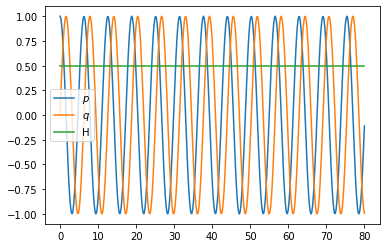

In [6]:
p, q = pq.T
H = 0.5 * (p ** 2 + q ** 2)

plt.plot(t, p, label="$p$")
plt.plot(t, q, label="$q$")
plt.plot(t, H, label="H")
plt.legend()

In [7]:
OBSERVATIONS_END = 200
SPARSITY_FACTOR = 0.6

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
    #np.full_like(H, fill_value=0.03)[:, np.newaxis]
), axis=1)

rng = np.random.default_rng(seed=42)
observations_mask_1 = rng.choice([False, True], size=OBSERVATIONS_END, p=[1 - SPARSITY_FACTOR, SPARSITY_FACTOR])
observations_mask_2 = rng.choice([False, True], size=OBSERVATIONS_END, p=[1 - SPARSITY_FACTOR, SPARSITY_FACTOR])

M = np.ones_like(X_true).astype(bool)
M[OBSERVATIONS_END:, 1:3] = False
#M[:OBSERVATIONS_END, 1]  = observations_mask_1
#M[:OBSERVATIONS_END, 2]  = observations_mask_2
M[:, 3] = False

rng = np.random.default_rng(42)
#X = rng.uniform(-0.15, 0.15, size=X_true.shape)
X = np.full_like(X_true, fill_value=0)
X[M] = X_true[M]
X[:, 3] = 0.1

Text(0.5, 1.0, 'q')

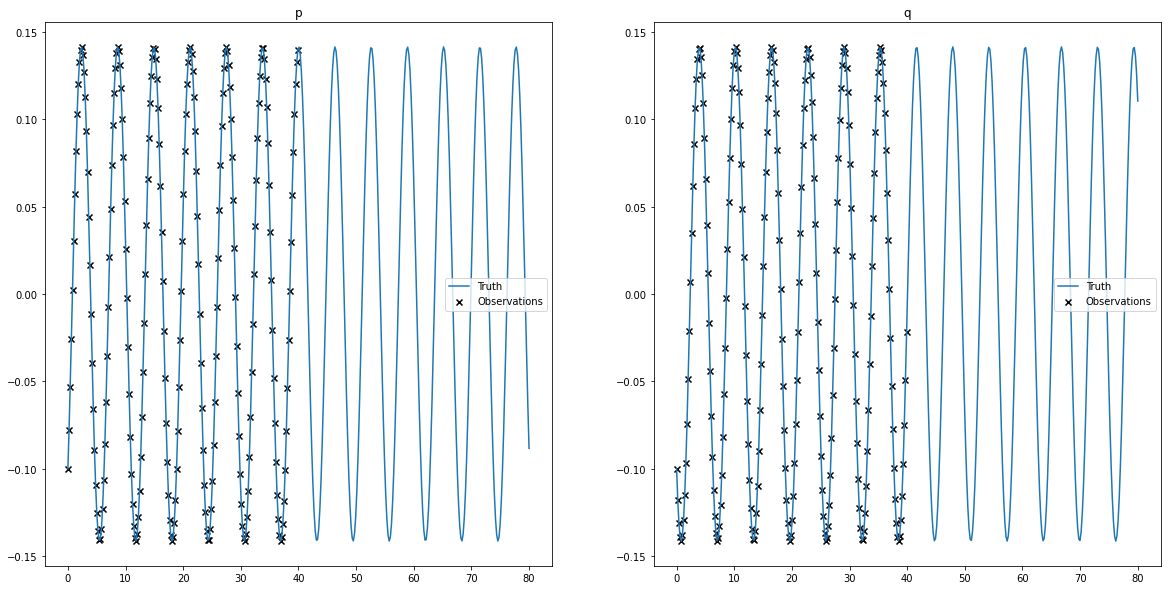

In [ ]:

_, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].plot(t, p, label="Truth")
axes[0].scatter(t[M[:, 1]], X[M[:, 1], 1], marker='x', label="Observations", color='black')
axes[0].legend()
axes[0].set_title("p")

axes[1].plot(t, q, label="Truth")
axes[1].scatter(t[M[:, 2]], X[M[:, 2], 2], marker='x', label="Observations", color='black')
axes[1].legend()
axes[1].set_title("q")

In [2]:
ms_graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

ms_graph.add_observable("t")
ms_graph.add_unknown_fn("t", "q", alpha=0.01, kernel="gaussian", kernel_parameters={"width": KP(1.0, learnable=True)})
ms_graph.add_unknown_fn("t", "p", alpha=0.01, kernel="gaussian", kernel_parameters={"width": KP(1.0, learnable=True)})

ms_graph.add_known_fn("p", "p_dot", derivative)
ms_graph.add_known_fn("q", "q_dot", derivative)
ms_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

ms_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")

ms_graph.add_aggregator(["p", "q"], "pq")
ms_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, kernel="gaussian", kernel_parameters={"width": KP(1.0, learnable=False)})
ms_graph.add_known_fn("H", "grad_H", derivative)

ms_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
ms_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")

def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, 0], p_dot_grad_H[:, 1:]
    return p_dot + grad_H[:, 1]

def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, 0], q_dot_grad_H[:, 1:]
    return q_dot - grad_H[:, 0]

ms_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
ms_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

NameError: name 'ComputationalGraph' is not defined

In [10]:
ms_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [11]:
Z = ms_graph.complete(X, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=5)

Loss: 0.0913:   0%|          | 6/10000 [01:14<34:39:16, 12.48s/it] 


{'q': {'width': DeviceArray(0.675244, dtype=float32)}, 'p': {'width': DeviceArray(1.456093, dtype=float32)}, 'H': {'width': 1.0}}


Loss: 0.0883:   0%|          | 6/10000 [01:16<35:13:15, 12.69s/it] 


{'q': {'width': DeviceArray(0.67916125, dtype=float32)}, 'p': {'width': DeviceArray(1.3600813, dtype=float32)}, 'H': {'width': 1.0}}


Loss: 0.0906:   0%|          | 4/10000 [01:24<58:33:41, 21.09s/it] 


{'q': {'width': DeviceArray(0.68166447, dtype=float32)}, 'p': {'width': DeviceArray(1.3496941, dtype=float32)}, 'H': {'width': 1.0}}


Loss: 0.0910:   0%|          | 2/10000 [01:21<112:37:28, 40.55s/it]


{'q': {'width': DeviceArray(0.6834163, dtype=float32)}, 'p': {'width': DeviceArray(1.3497972, dtype=float32)}, 'H': {'width': 1.0}}


Loss: 0.0910:   0%|          | 3/10000 [01:20<74:42:14, 26.90s/it] 


{'q': {'width': DeviceArray(0.6837829, dtype=float32)}, 'p': {'width': DeviceArray(1.3498319, dtype=float32)}, 'H': {'width': 1.0}}


Loss: 0.0910:   0%|          | 2/10000 [01:18<109:35:40, 39.46s/it]


{'q': {'width': DeviceArray(0.68461525, dtype=float32)}, 'p': {'width': DeviceArray(1.3498584, dtype=float32)}, 'H': {'width': 1.0}}


Loss: 1.3125:   0%|          | 5/10000 [00:20<11:17:34,  4.07s/it]


In [12]:
ms_graph.report_kernel_params()

{'q': {'width': DeviceArray(0.675244, dtype=float32)}, 'p': {'width': DeviceArray(1.456093, dtype=float32)}, 'H': {'width': 1.0}}


## CGC Extrapolation

In [13]:
mse_p = jnp.mean((p[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)

print(f"Extrapolation MSE on P = {mse_p:.9f}")
print(f"Extrapolation MSE on Q = {mse_q:.9f}")

Extrapolation MSE on P = 0.000006869
Extrapolation MSE on Q = 0.000006546


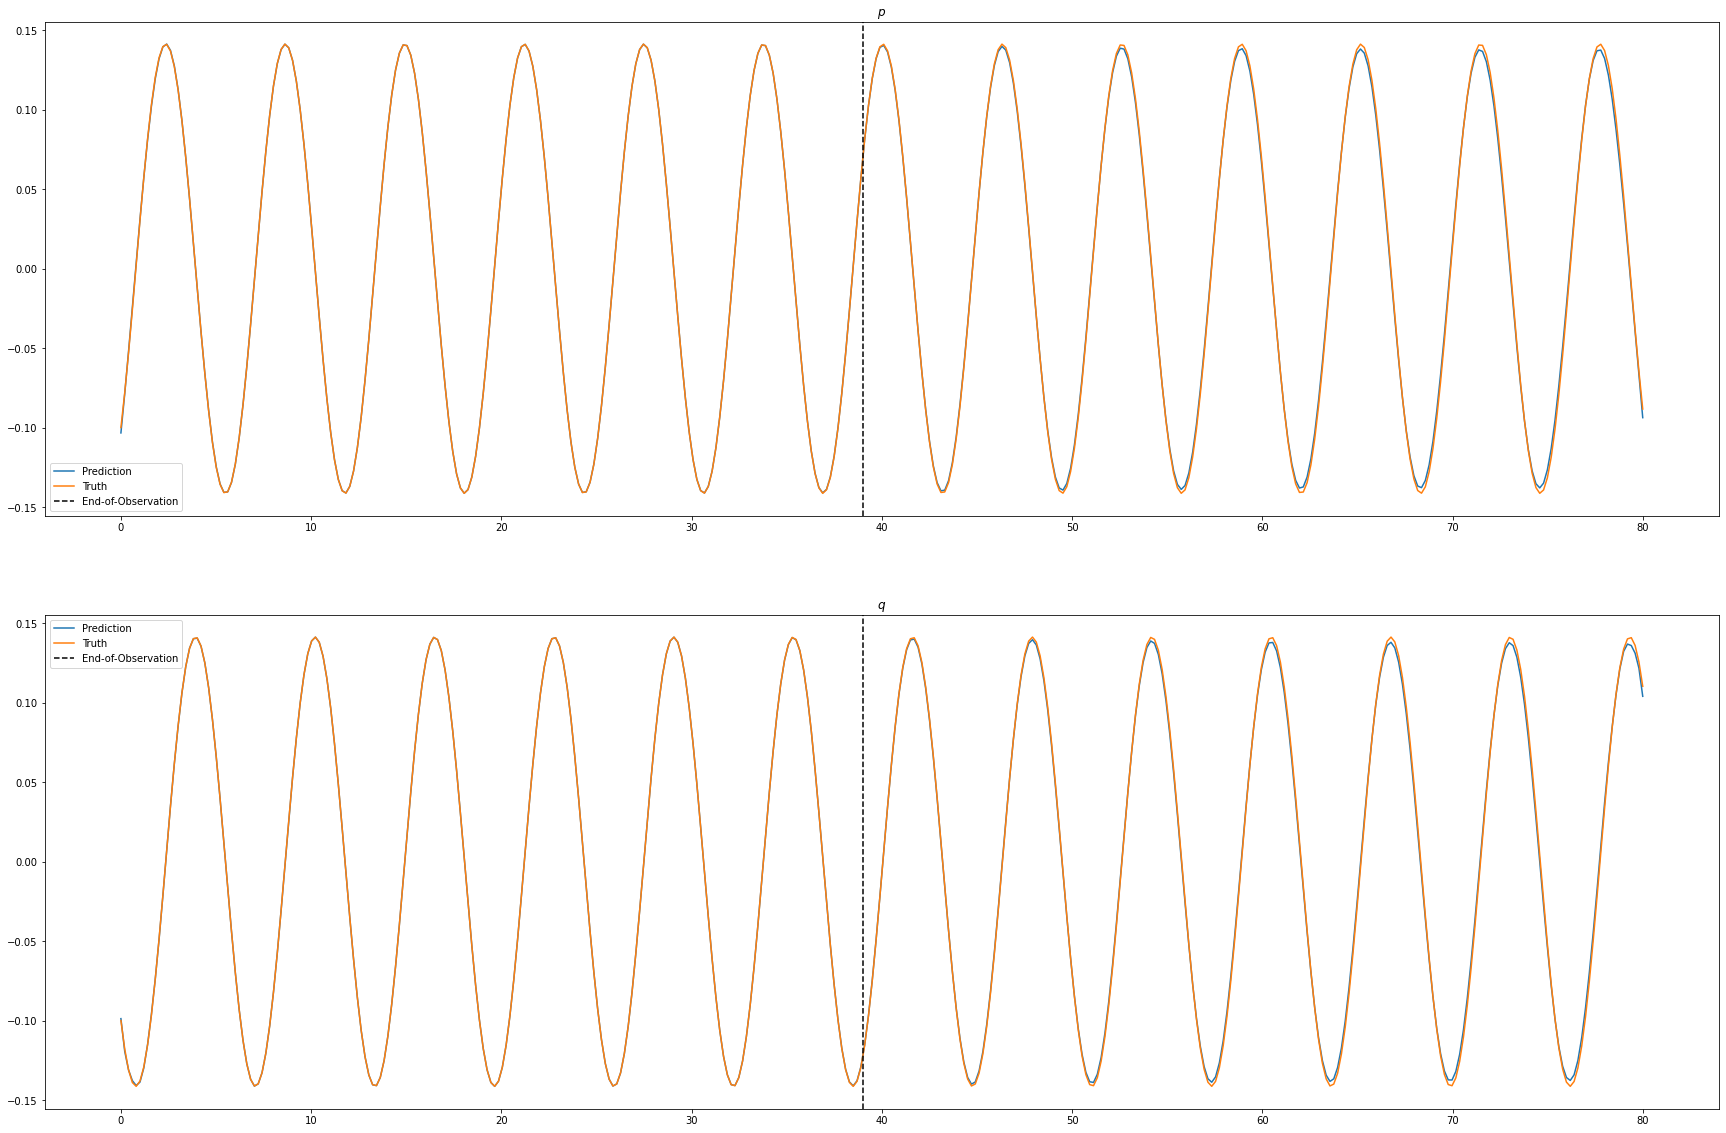

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t, Z[:, 1], label="Prediction")
axes[0].plot(t, p, label="Truth")
axes[0].set_title("$p$")
axes[0].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[0].legend()

axes[1].plot(t, Z[:, 2], label="Prediction")
axes[1].plot(t, q, label="Truth")
axes[1].set_title("$q$")
axes[1].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[1].legend()

## Symplectic Integeration Extrapolation

In [5]:
H_ms_est = get_hamiltonian_from(ms_graph, Z[:200])
H_ms_est_grad = jax.jit(jax.grad(H_ms_est))

t = np.linspace(0, 80, 400)
pq_symplectic = hamiltonian_symplectic_int(H_ms_est_grad, [-0.1, -0.1], t)
pq_symplectic = jnp.squeeze(pq_symplectic)

NameError: name 'ms_graph' is not defined

In [16]:
mse_p = jnp.mean((p[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0]) ** 2)

print(f"Extrapolation MSE on P = {mse_p:.9f}")
print(f"Extrapolation MSE on Q = {mse_q:.9f}")

Extrapolation MSE on P = 0.000007498
Extrapolation MSE on Q = 0.000007258


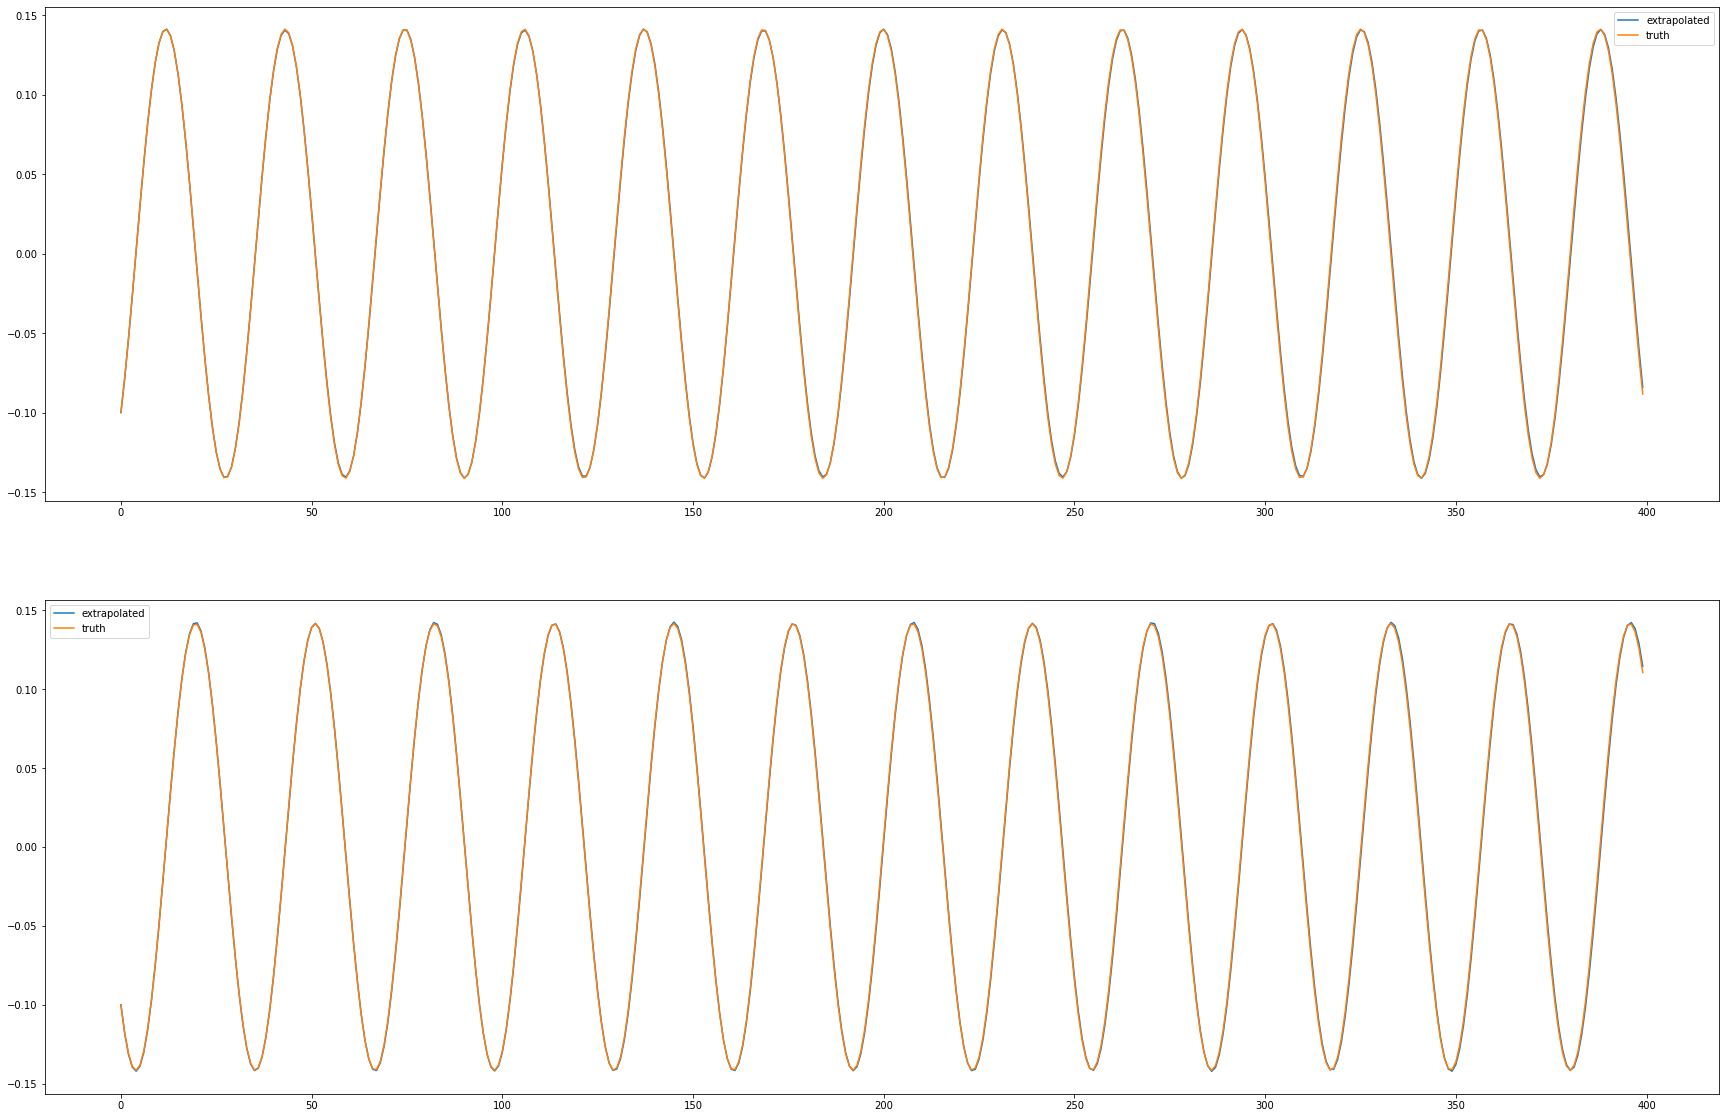

In [17]:
_, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(pq_symplectic[:, 1], label="extrapolated")
axes[0].plot(p, label="truth")
axes[0].legend()
axes[1].plot(pq_symplectic[:, 0], label="extrapolated")
axes[1].plot(q, label="truth")
axes[1].legend()

# Two-Mass-Three-Springs System

## Data Generation

In [5]:
def m2s3_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 + (q2 - q1),
        -q2 - (q2 - q1),
        p1,
        p2
    ]
    
    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(m2s3_system_ode, [1.0, 0.0, 0.0, 0.0], t)

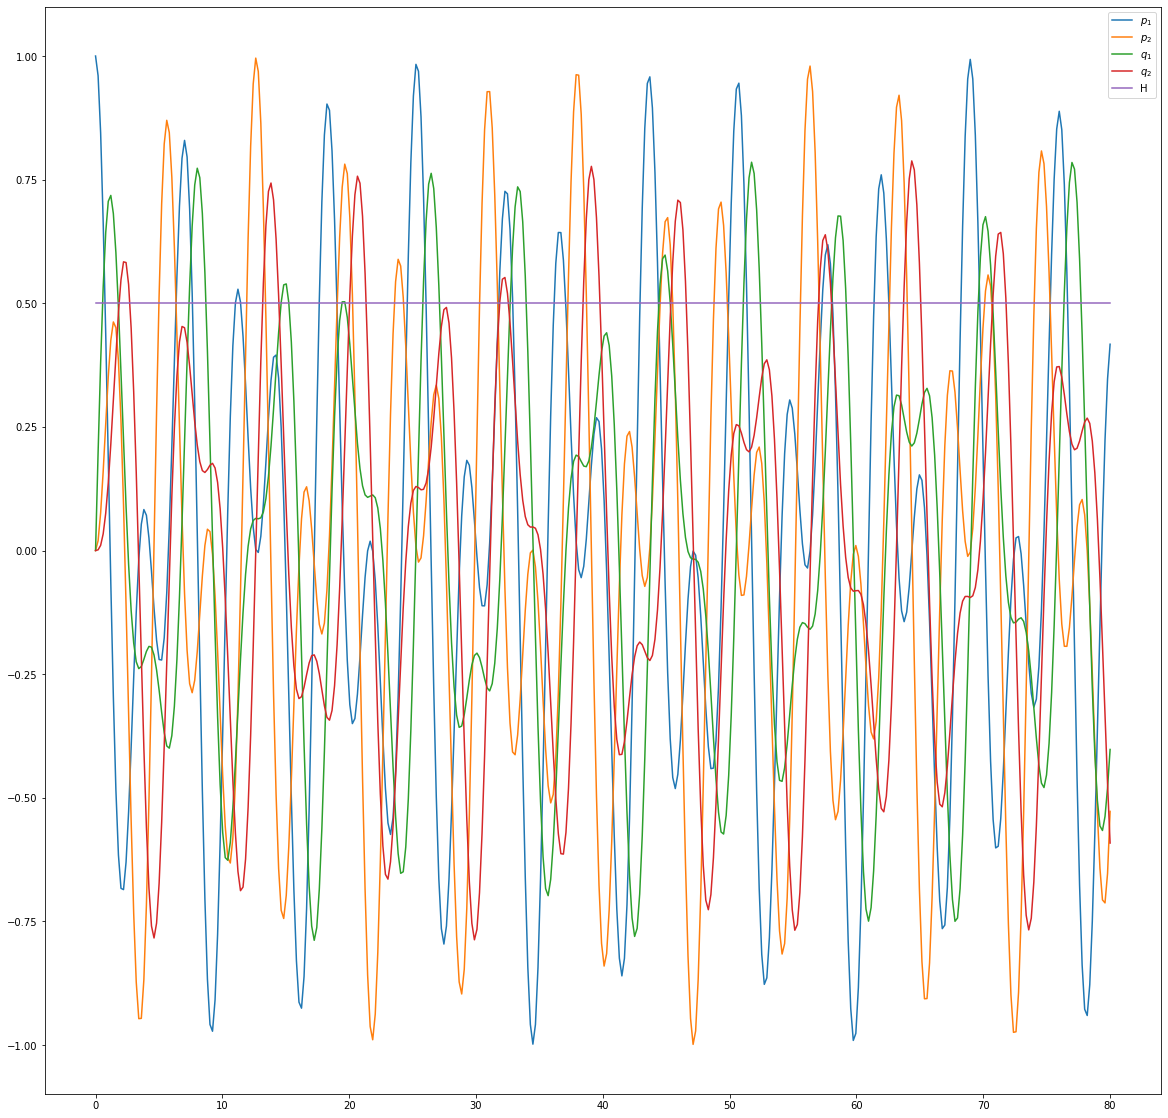

In [6]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + (q2 - q1) ** 2 + p1 ** 2 + p2 ** 2)
plt.figure(figsize=(20, 20))
plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [7]:
OBSERVATIONS_END = 100
SPARSITY_FACTOR = 0.6

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

rng = np.random.default_rng(seed=42)
observations_mask_1 = rng.choice([False, True], size=OBSERVATIONS_END, p=[1 - SPARSITY_FACTOR, SPARSITY_FACTOR])

M = np.ones_like(X_true).astype(bool)
M[OBSERVATIONS_END:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [8]:
rng = np.random.default_rng(seed=42)

m2s3_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

m2s3_graph.add_observable("t")
#m2s3_graph.add_unknown_fn("t", "p1", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})
#m2s3_graph.add_unknown_fn("t", "p2", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})
#m2s3_graph.add_unknown_fn("t", "q1", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})
#m2s3_graph.add_unknown_fn("t", "q2", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})

m2s3_graph.add_unknown_fn("t", "p1", alpha=1e-6, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
m2s3_graph.add_unknown_fn("t", "p2", alpha=1e-6, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
m2s3_graph.add_unknown_fn("t", "q1", alpha=1e-6, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
m2s3_graph.add_unknown_fn("t", "q2", alpha=1e-6, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})


m2s3_graph.add_known_fn("p1", "p1_dot", derivative)
m2s3_graph.add_known_fn("p2", "p2_dot", derivative)
m2s3_graph.add_known_fn("q1", "q1_dot", derivative)
m2s3_graph.add_known_fn("q2", "q2_dot", derivative)

m2s3_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
m2s3_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
m2s3_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

m2s3_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
m2s3_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

m2s3_graph.add_unknown_fn(
    "pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="big-kernel",
    kernel_parameters={
        "gaussian_width": KP(1.0, learnable=True),
        "gaussian_weight": KP(1.0, learnable=True, weight=True),
        "quadratic_constant": KP(1.0, learnable=True),
        "quadratic_weight": KP(1.0, learnable=True, weight=True),
        "periodic_periodicity": KP(1.0 ,learnable=True),
        "periodic_scale": KP(1.0, learnable=True),
        "periodic_weight": KP(0.0, learnable=False, weight=True)
        #"cubic_constant": KP(1.0, learnable=True),
        #"cubic_weight": KP(0.33, learnable=True, weight=True),
        #"periodic_weight": KP(1.0, learnable=True, weight=True),
        #"poly_weight": KP(1.0, learnable=True, weight=True),
        #"poly_constant": KP(1.0, learnable=True),
        #"poly_exponant": KP(1.0, learnable=True)
        #"locally_periodic_periodicity": KP(1.0, learnable=True),
        #"locally_periodic_scale": KP(1.0, learnable=True),
        #"locally_periodic_locality_scale": KP(1.0, learnable=True),
        #"locally_periodic_weight": KP(1.0, learnable=True, weight=True)
    }
)
#m2s3_graph.add_unknown_fn("pq", "H_gaussian", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="gaussian", kernel_parameters={
#    "scale": KP(1.0, learnable=True),
#    "weight": KP(1.0, learnable=True, weight=True)
#})
#m2s3_graph.add_unknown_fn("pq", "H_quadratic", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="quadratic", kernel_parameters={
#    "constant": KP(1.0, learnable=True),
#    "weight": KP(1.0, learnable=True, weight=True)
#})
#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, kernel="quadratic", kernel_parameters={"constant": KP(1.0, learnable=True)})
#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="polynomial", kernel_parameters={
#    "constant": KP(1.0, learnable=True),
#    "exponent": KP(1.0, learnable=True)
#    })
#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="quadratic", kernel_parameters={"constant": KP(1.0, learnable=True)})
#m2s3_graph.add_aggregator(["H_gaussian", "H_quadratic"], "H_components")
#m2s3_graph.add_known_fn("H_components", "H", lambda H_components: H_components[:, 0] + H_components[:, 1])
#
#m2s3_graph.add_known_fn("H_gaussian", "H_gaussian_grad", derivative)
#m2s3_graph.add_known_fn("H_quadratic", "H_quadratic_grad", derivative)
#m2s3_graph.add_aggregator(["H_gaussian_grad", "H_quadratic_grad"], "H_grad_components")
#m2s3_graph.add_known_fn("H_grad_components", "grad_H", lambda C: C[:, 0, :] + C[:, 1, :])

#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="quadratic + gaussian", kernel_parameters={
#    "gaussian_scale": KP(1.0),
#    "gaussian_weight": KP(1.0, weight=True),
#    "quadratic_constant": KP(1.0),
#    "quadratic_weight": KP(1.0, weight=True)
#})

m2s3_graph.add_known_fn("H", "grad_H", derivative)

m2s3_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

m2s3_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

m2s3_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
m2s3_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [9]:
m2s3_graph.set_uknknow_fns_parameters_range()

In [9]:
m2s3_graph.set_loss_multipliers(constraints_loss_multiplier=10000, unknown_functions_loss_multiplier=0)

In [10]:
m2s3_graph.report_kernel_params()

{'p1': {'scale': 1.0}, 'p2': {'scale': 1.0}, 'q1': {'scale': 1.0}, 'q2': {'scale': 1.0}, 'H': {'gaussian_width': 1.0, 'gaussian_weight': 1.0, 'quadratic_constant': 1.0, 'quadratic_weight': 1.0, 'periodic_periodicity': 1.0, 'periodic_scale': 1.0, 'periodic_weight': 0.0}}


In [11]:
params, *_ = m2s3_graph._gather_parameters()
tm = np.ones_like(params)
m2s3_graph._unknown_functions["p1"].kflow_loss(params, X[:200, :], M, params, tm)

Array(0.06780048, dtype=float32)

In [11]:
Z = m2s3_graph.complete(X, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=5)

(Parameters Pass) Loss: 0.014140608:   0%|          | 628/500000 [00:59<13:05:21, 10.60it/s]


Stopped after 50 steps with no improvment in Loss


(Weights Pass) Loss: 0.013306493:   0%|          | 459/500000 [00:13<4:08:48, 33.46it/s]


Stopped after 50 steps with no improvment in Loss
{'p1': {'scale': Array(0.73099184, dtype=float64)}, 'p2': {'scale': Array(0.54043915, dtype=float64)}, 'q1': {'scale': Array(1.20991688, dtype=float64)}, 'q2': {'scale': Array(1.20508609, dtype=float64)}, 'H': {'gaussian_width': Array(2.18862733, dtype=float64), 'gaussian_weight': Array(0.83828342, dtype=float64), 'quadratic_constant': Array(1.00585351, dtype=float64), 'quadratic_weight': Array(1.84258706, dtype=float64), 'periodic_periodicity': Array(1., dtype=float64), 'periodic_scale': Array(1., dtype=float64), 'periodic_weight': 0.0}}


(Parameters Pass) Loss: 0.000637749:   0%|          | 178/500000 [01:17<60:35:11,  2.29it/s]


Stopped after 50 steps with no improvment in Loss


(Weights Pass) Loss: 0.000609890:   0%|          | 131/500000 [00:30<31:59:18,  4.34it/s]


Stopped after 50 steps with no improvment in Loss
{'p1': {'scale': Array(0.90241874, dtype=float64)}, 'p2': {'scale': Array(1.65751952, dtype=float64)}, 'q1': {'scale': Array(1.03128416, dtype=float64)}, 'q2': {'scale': Array(1.20773473, dtype=float64)}, 'H': {'gaussian_width': Array(2.2186538, dtype=float64), 'gaussian_weight': Array(0.80484401, dtype=float64), 'quadratic_constant': Array(1.00587198, dtype=float64), 'quadratic_weight': Array(2.03016573, dtype=float64), 'periodic_periodicity': Array(1., dtype=float64), 'periodic_scale': Array(1., dtype=float64), 'periodic_weight': 0.0}}


(Parameters Pass) Loss: 0.003971050:   0%|          | 107/500000 [00:39<51:48:47,  2.68it/s]


Stopped after 50 steps with no improvment in Loss


(Weights Pass) Loss: 0.001774258:   0%|          | 449/500000 [01:26<26:40:19,  5.20it/s]


Stopped after 50 steps with no improvment in Loss
{'p1': {'scale': Array(0.93421084, dtype=float64)}, 'p2': {'scale': Array(1.59234615, dtype=float64)}, 'q1': {'scale': Array(1.02466715, dtype=float64)}, 'q2': {'scale': Array(1.30744697, dtype=float64)}, 'H': {'gaussian_width': Array(2.23101633, dtype=float64), 'gaussian_weight': Array(0.00683611, dtype=float64), 'quadratic_constant': Array(1.00579084, dtype=float64), 'quadratic_weight': Array(5.22954803, dtype=float64), 'periodic_periodicity': Array(1., dtype=float64), 'periodic_scale': Array(1., dtype=float64), 'periodic_weight': 0.0}}


(Parameters Pass) Loss: 0.001622621:   0%|          | 55/500000 [00:30<76:56:40,  1.80it/s] 


Stopped after 50 steps with no improvment in Loss


(Weights Pass) Loss: 0.001620668:   0%|          | 51/500000 [00:09<25:12:01,  5.51it/s]


Stopped after 50 steps with no improvment in Loss
{'p1': {'scale': Array(0.99233176, dtype=float64)}, 'p2': {'scale': Array(1.5794383, dtype=float64)}, 'q1': {'scale': Array(1.01831386, dtype=float64)}, 'q2': {'scale': Array(1.30704275, dtype=float64)}, 'H': {'gaussian_width': Array(2.23102326, dtype=float64), 'gaussian_weight': Array(0.00610433, dtype=float64), 'quadratic_constant': Array(1.00580797, dtype=float64), 'quadratic_weight': Array(5.2444343, dtype=float64), 'periodic_periodicity': Array(1., dtype=float64), 'periodic_scale': Array(1., dtype=float64), 'periodic_weight': 0.0}}


(Parameters Pass) Loss: 0.002057295:   0%|          | 51/500000 [00:29<79:32:12,  1.75it/s] 


Stopped after 50 steps with no improvment in Loss


(Weights Pass) Loss: 0.002059603:   0%|          | 51/500000 [00:09<25:44:00,  5.40it/s]


Stopped after 50 steps with no improvment in Loss
{'p1': {'scale': Array(0.99834787, dtype=float64)}, 'p2': {'scale': Array(1.57902715, dtype=float64)}, 'q1': {'scale': Array(1.03831248, dtype=float64)}, 'q2': {'scale': Array(1.33145525, dtype=float64)}, 'H': {'gaussian_width': Array(2.231031, dtype=float64), 'gaussian_weight': Array(0.00556642, dtype=float64), 'quadratic_constant': Array(1.00583421, dtype=float64), 'quadratic_weight': Array(5.25625769, dtype=float64), 'periodic_periodicity': Array(1., dtype=float64), 'periodic_scale': Array(1., dtype=float64), 'periodic_weight': 0.0}}


(Parameters Pass) Loss: 0.001877397:   0%|          | 51/500000 [00:29<80:44:47,  1.72it/s] 


Stopped after 50 steps with no improvment in Loss


(Weights Pass) Loss: 0.001878617:   0%|          | 51/500000 [00:09<25:56:22,  5.35it/s]


Stopped after 50 steps with no improvment in Loss
{'p1': {'scale': Array(0.99904601, dtype=float64)}, 'p2': {'scale': Array(1.57854105, dtype=float64)}, 'q1': {'scale': Array(1.03210345, dtype=float64)}, 'q2': {'scale': Array(1.33718361, dtype=float64)}, 'H': {'gaussian_width': Array(2.23103561, dtype=float64), 'gaussian_weight': Array(0.00507681, dtype=float64), 'quadratic_constant': Array(1.00585282, dtype=float64), 'quadratic_weight': Array(5.26785348, dtype=float64), 'periodic_periodicity': Array(1., dtype=float64), 'periodic_scale': Array(1., dtype=float64), 'periodic_weight': 0.0}}


 Loss: 1969.7839:   0%|          | 2/10000 [00:23<32:26:37, 11.68s/it]


In [12]:
m2s3_graph.report_kernel_params()

{'p1': {'scale': Array(0.73099184, dtype=float64)}, 'p2': {'scale': Array(0.54043915, dtype=float64)}, 'q1': {'scale': Array(1.20991688, dtype=float64)}, 'q2': {'scale': Array(1.20508609, dtype=float64)}, 'H': {'gaussian_width': Array(2.18862733, dtype=float64), 'gaussian_weight': Array(0.83828342, dtype=float64), 'quadratic_constant': Array(1.00585351, dtype=float64), 'quadratic_weight': Array(1.84258706, dtype=float64), 'periodic_periodicity': Array(1., dtype=float64), 'periodic_scale': Array(1., dtype=float64), 'periodic_weight': 0.0}}


In [13]:
m2s3_graph.report_kernel_params()

{'p1': {'period': Array(0.71391916, dtype=float64), 'period_scale': Array(4.3202491, dtype=float64), 'locality_scale': Array(0.64182105, dtype=float64)}, 'p2': {'period': Array(0.93441807, dtype=float64), 'period_scale': Array(2.74017849, dtype=float64), 'locality_scale': Array(0.6689413, dtype=float64)}, 'q1': {'period': Array(0.93672668, dtype=float64), 'period_scale': Array(2.46261382, dtype=float64), 'locality_scale': Array(0.71799726, dtype=float64)}, 'q2': {'period': Array(0.90574691, dtype=float64), 'period_scale': Array(2.50903196, dtype=float64), 'locality_scale': Array(0.69789171, dtype=float64)}, 'H': {'gaussian_width': Array(0.933583, dtype=float64), 'gaussian_weight': Array(220.59959699, dtype=float64), 'quadratic_constant': Array(1.00169971, dtype=float64), 'quadratic_weight': Array(2597.95160782, dtype=float64)}}


In [14]:
m2s3_graph.report_kernel_params()

{'p1': {'period': Array(0.71391916, dtype=float64), 'period_scale': Array(4.3202491, dtype=float64), 'locality_scale': Array(0.64182105, dtype=float64)}, 'p2': {'period': Array(0.93441807, dtype=float64), 'period_scale': Array(2.74017849, dtype=float64), 'locality_scale': Array(0.6689413, dtype=float64)}, 'q1': {'period': Array(0.93672668, dtype=float64), 'period_scale': Array(2.46261382, dtype=float64), 'locality_scale': Array(0.71799726, dtype=float64)}, 'q2': {'period': Array(0.90574691, dtype=float64), 'period_scale': Array(2.50903196, dtype=float64), 'locality_scale': Array(0.69789171, dtype=float64)}, 'H': {'gaussian_width': Array(0.933583, dtype=float64), 'gaussian_weight': Array(220.59959699, dtype=float64), 'quadratic_constant': Array(1.00169971, dtype=float64), 'quadratic_weight': Array(2597.95160782, dtype=float64)}}


## CGC Extrapolation

In [13]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 3]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 4]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.042978180
Extrapolation MSE on Q1 = 0.022036427
Extrapolation MSE on P2 = 0.040732764
Extrapolation MSE on Q2 = 0.020314131


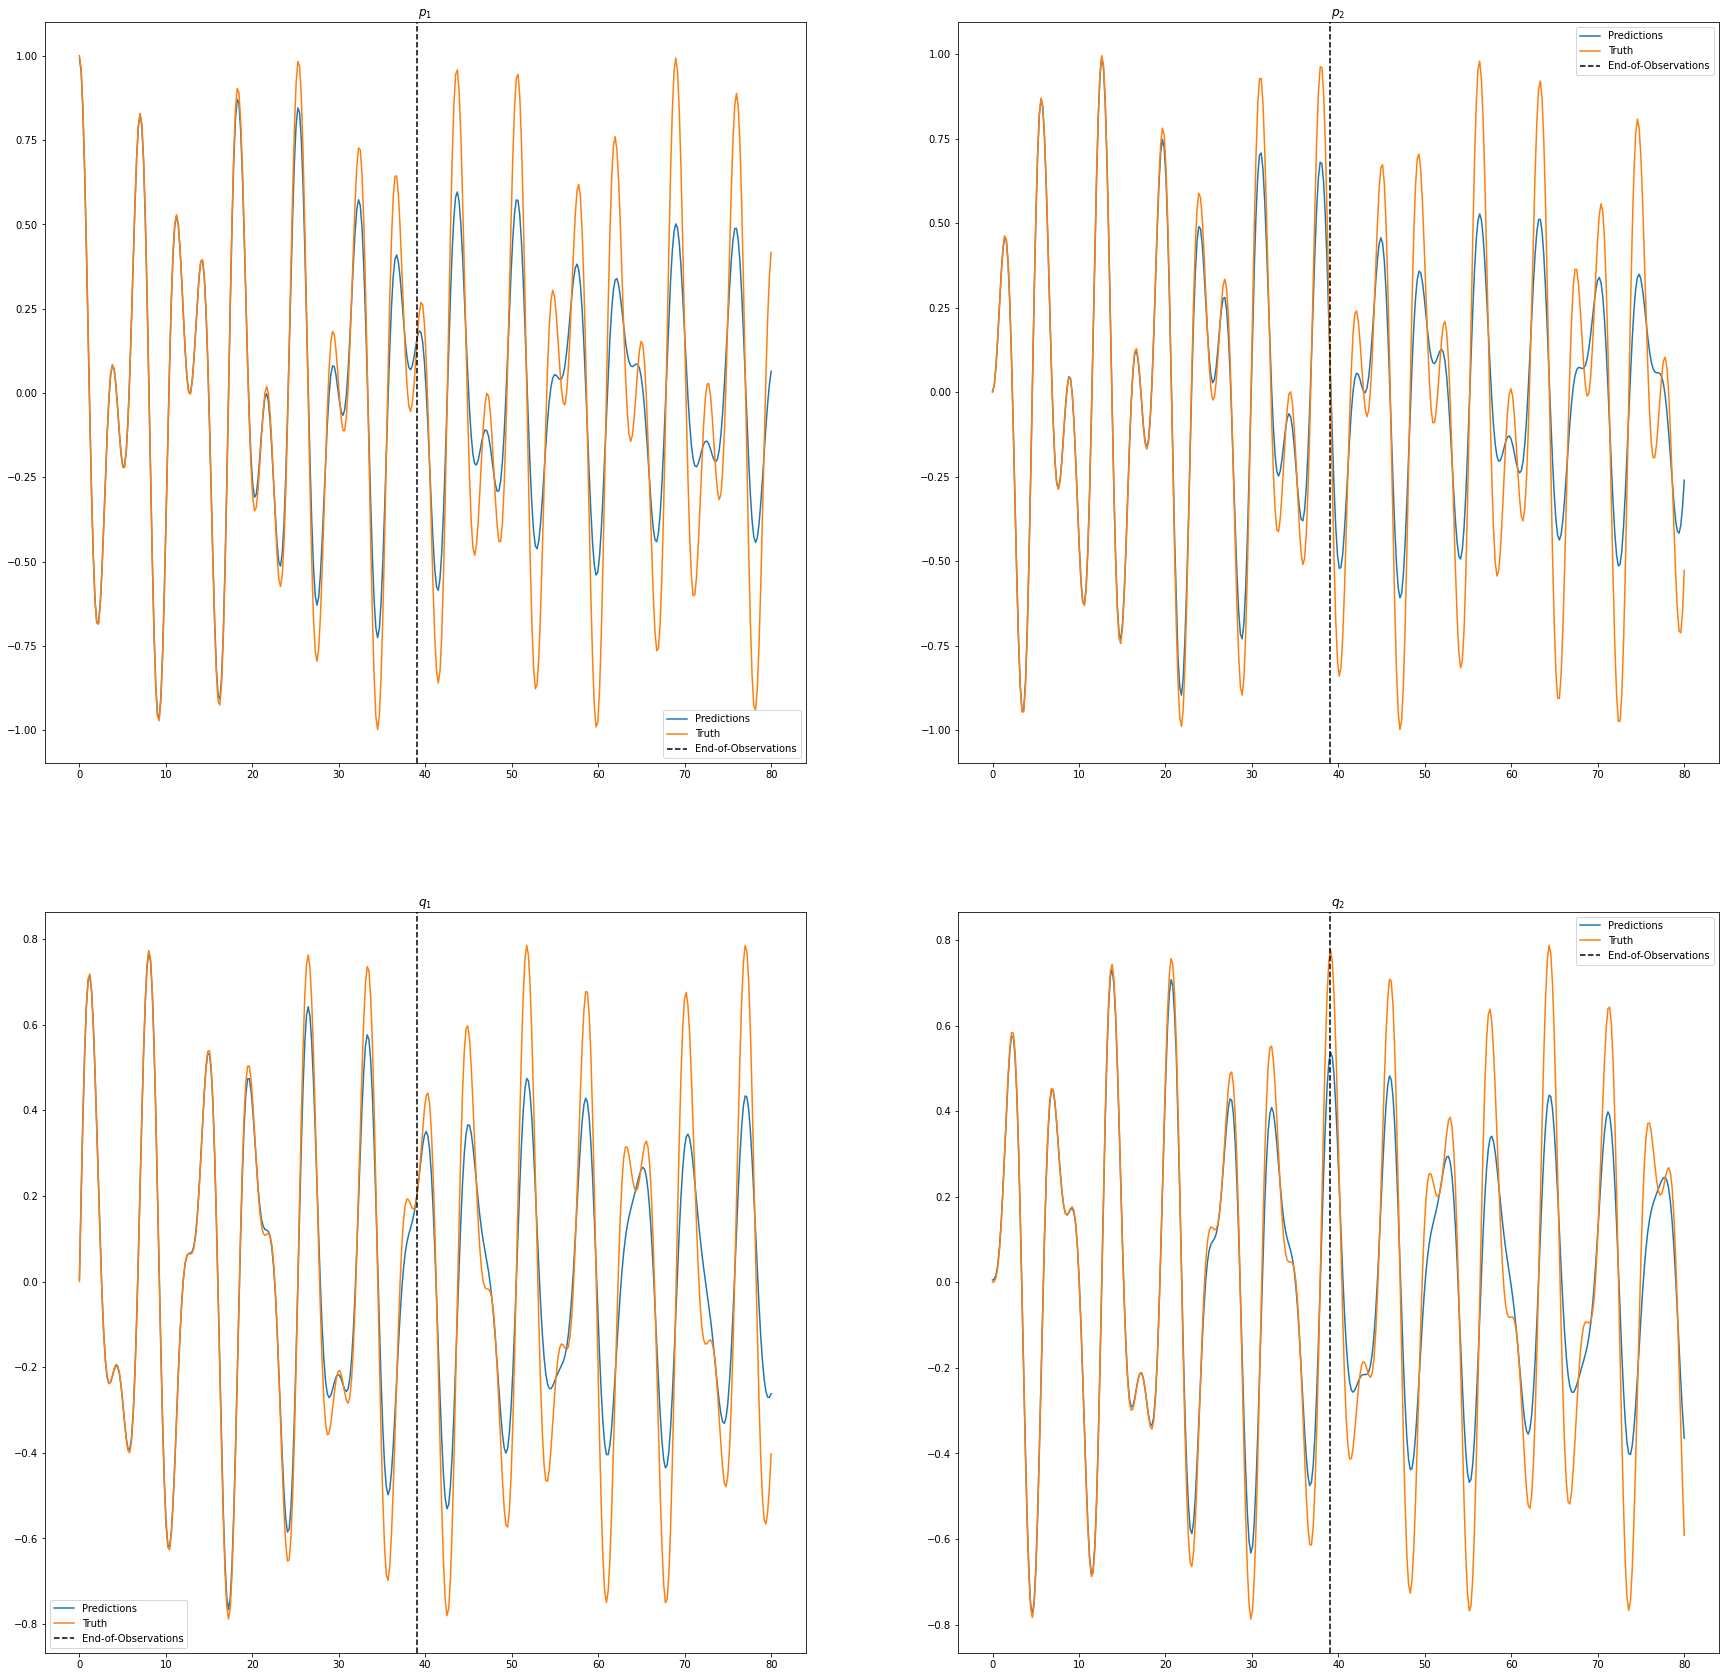

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

## Symplectic Integeration Extrapolation

In [15]:
H_m2s3_est = get_hamiltonian_from(m2s3_graph, Z)
H_m2s3_est_grad = jax.jit(jax.grad(H_m2s3_est))

pq_symplectic = hamiltonian_symplectic_int(H_m2s3_est_grad, [1.0, 0, 0, 0], t, order=2)
pq_symplectic = jnp.squeeze(pq_symplectic)

In [17]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1, 0]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0, 0]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1, 1]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0, 1]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.007765353
Extrapolation MSE on Q1 = 0.004087590
Extrapolation MSE on P2 = 0.008376381
Extrapolation MSE on Q2 = 0.004251264


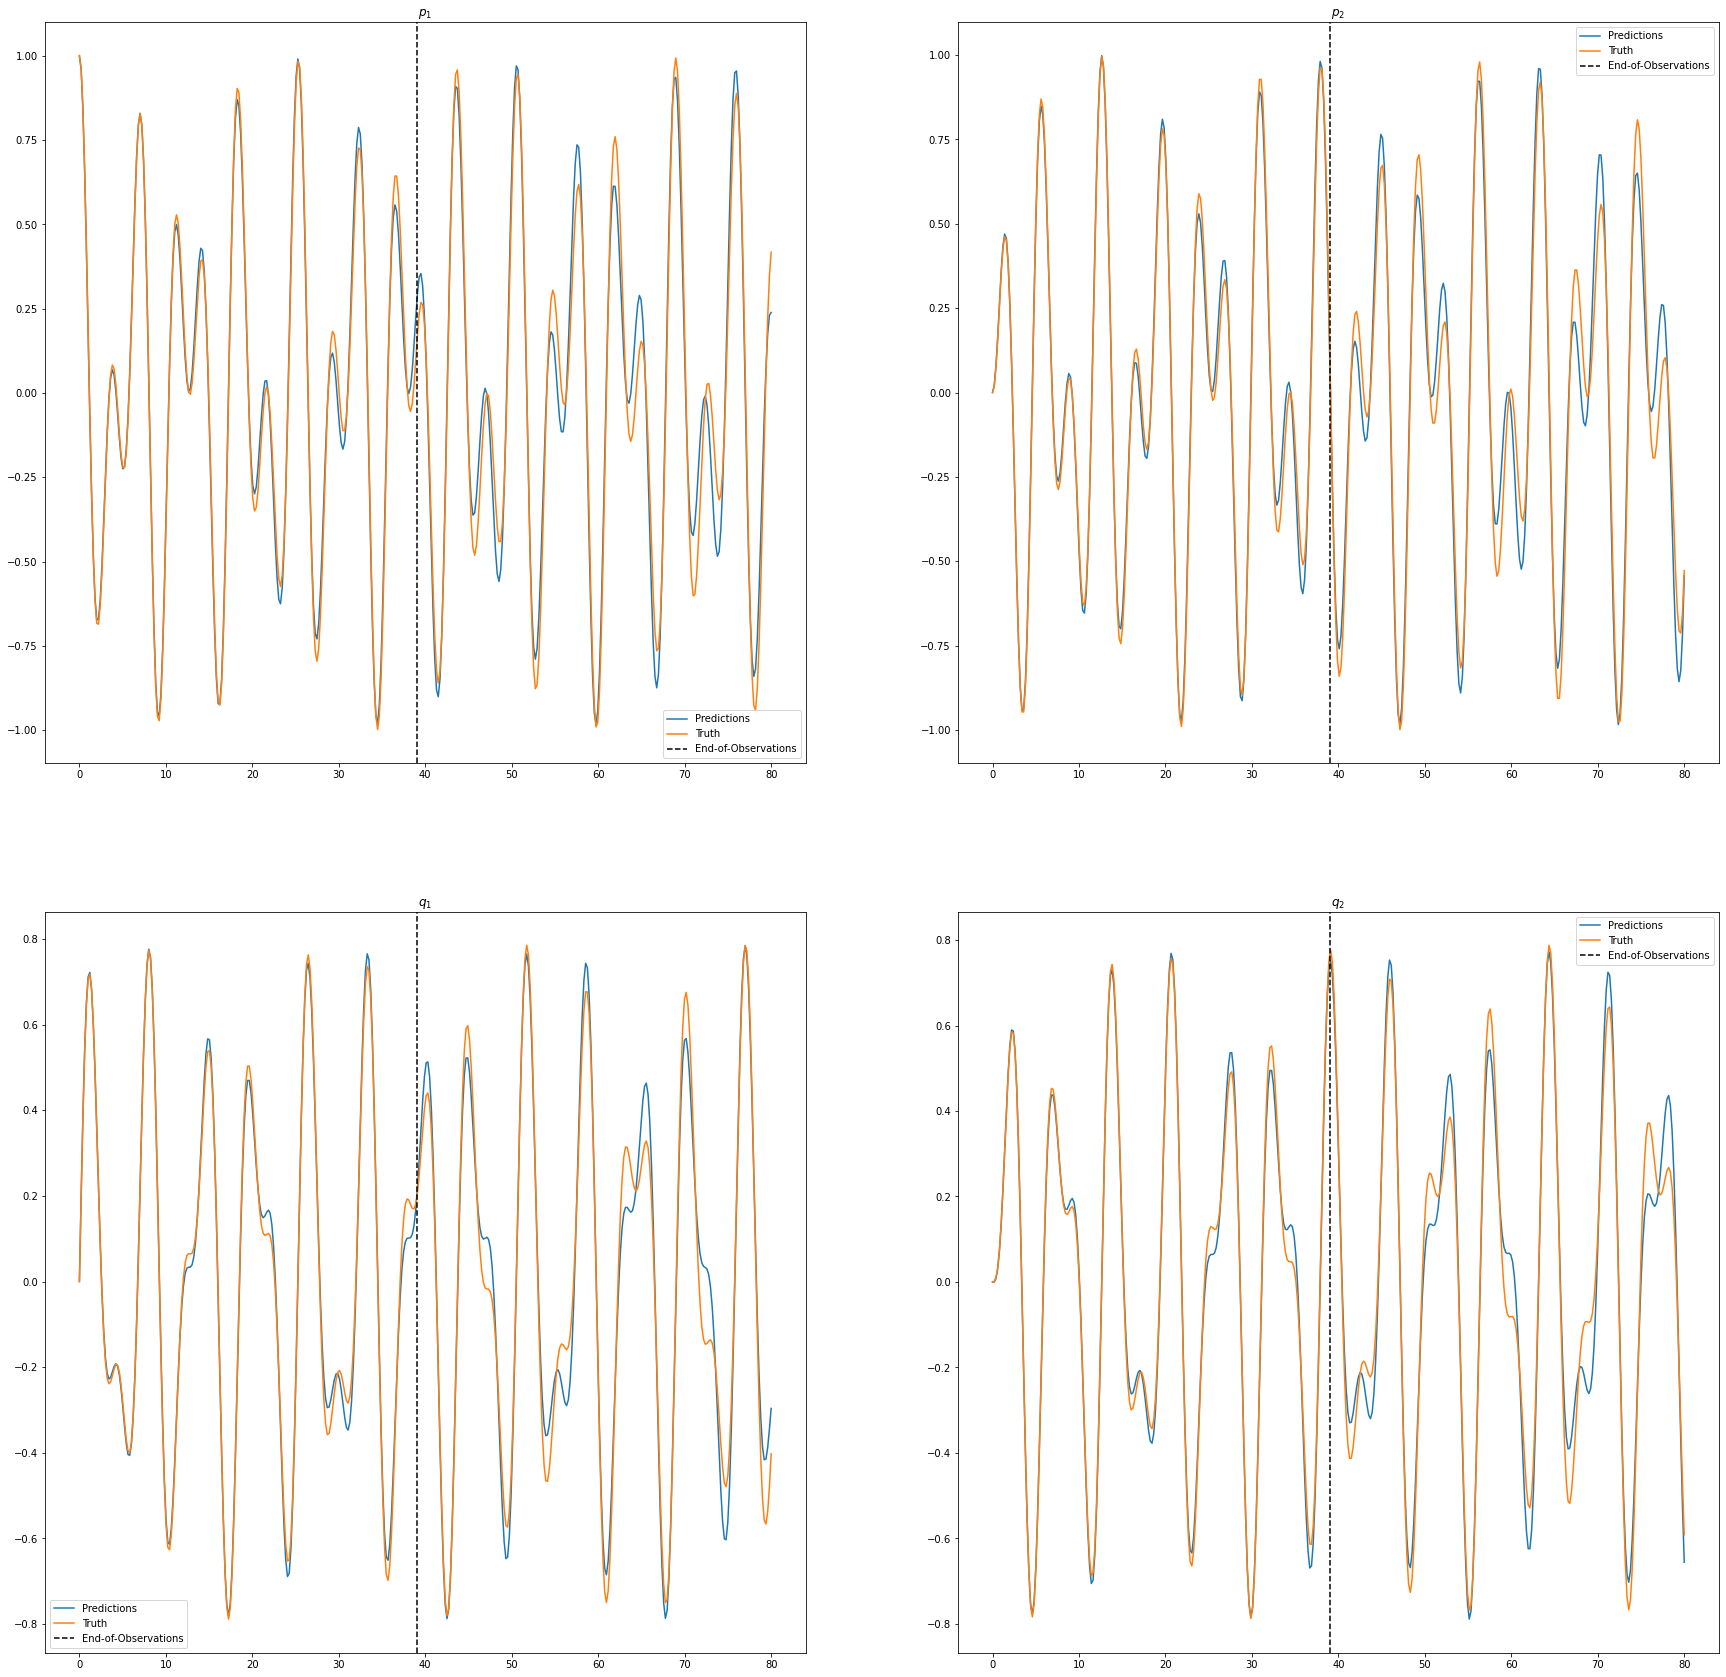

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "est", "truth", "label"])

plots_data = [
    PlotData((0, 0), pq_symplectic[:, 1, 0], p1, "$p_1$"),
    PlotData((0, 1), pq_symplectic[:, 1, 1], p2, "$p_2$"),
    PlotData((1, 0), pq_symplectic[:, 0, 0], q1, "$q_1$"),
    PlotData((1, 1), pq_symplectic[:, 0, 1], q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, data.est, label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

# Hénon–Heiles System

## Data Generation

In [6]:
def hh_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 - 2 * q1 * q2,
        -q2 - q1 ** 2 + q2 ** 2,
        p1,
        p2
    ]

    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(hh_system_ode, [0.1, -0.1, 0.2, -0.1], t)


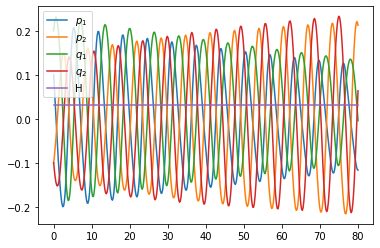

In [7]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + p1 ** 2 + p2 ** 2) + q2 * q1 ** 2 - (1/3) * q2 ** 3

plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [8]:
OBSERVATIONS_END = 200

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

M = np.ones_like(X_true).astype(bool)
M[OBSERVATIONS_END:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [17]:
hh_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

hh_graph.add_observable("t")
hh_graph.add_unknown_fn("t", "p1", alpha=0.01, gamma=1)#LearnableParameter(1.2))
hh_graph.add_unknown_fn("t", "p2", alpha=0.01, gamma=1)#LearnableParameter(1.2))
hh_graph.add_unknown_fn("t", "q1", alpha=0.01, gamma=1)#LearnableParameter(1.2))
hh_graph.add_unknown_fn("t", "q2", alpha=0.01, gamma=1)#LearnableParameter(1.2))

hh_graph.add_known_fn("p1", "p1_dot", derivative)
hh_graph.add_known_fn("p2", "p2_dot", derivative)
hh_graph.add_known_fn("q1", "q1_dot", derivative)
hh_graph.add_known_fn("q2", "q2_dot", derivative)

hh_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
hh_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
hh_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

hh_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
hh_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

hh_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, gamma=LearnableParameter(1.0), kernel="poly+rbf")
hh_graph.add_known_fn("H", "grad_H", derivative)

hh_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

hh_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

hh_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
hh_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [18]:
hh_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [19]:
Z = hh_graph.complete(X, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=5)

Loss: -1489.5770:   0%|          | 2/10000 [00:33<47:03:45, 16.95s/it]


{'p1': 1.0, 'p2': 1.0, 'q1': 1.0, 'q2': 1.0, 'H': 0.13070589303970337}


Loss: -464.2717:   0%|          | 2/10000 [00:29<41:03:52, 14.79s/it]


{'p1': 1.0, 'p2': 1.0, 'q1': 1.0, 'q2': 1.0, 'H': 0.13044726848602295}


Loss: -23948.5176:   0%|          | 1/10000 [00:32<90:30:34, 32.59s/it]


{'p1': 1.0, 'p2': 1.0, 'q1': 1.0, 'q2': 1.0, 'H': 0.13043943047523499}


  0%|          | 0/10000 [00:19<?, ?it/s]


{'p1': 1.0, 'p2': 1.0, 'q1': 1.0, 'q2': 1.0, 'H': 0.13043943047523499}


Loss: 3248.5994:   0%|          | 1/10000 [00:48<134:18:40, 48.36s/it]


In [14]:
hh_graph.report_kernel_params()

{'p1': 1.0, 'p2': 1.0, 'q1': 1.0, 'q2': 1.0, 'H': 2.313931941986084}


In [15]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 3]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 4]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.000675208
Extrapolation MSE on Q1 = 0.000784985
Extrapolation MSE on P2 = 0.000794256
Extrapolation MSE on Q2 = 0.000806389


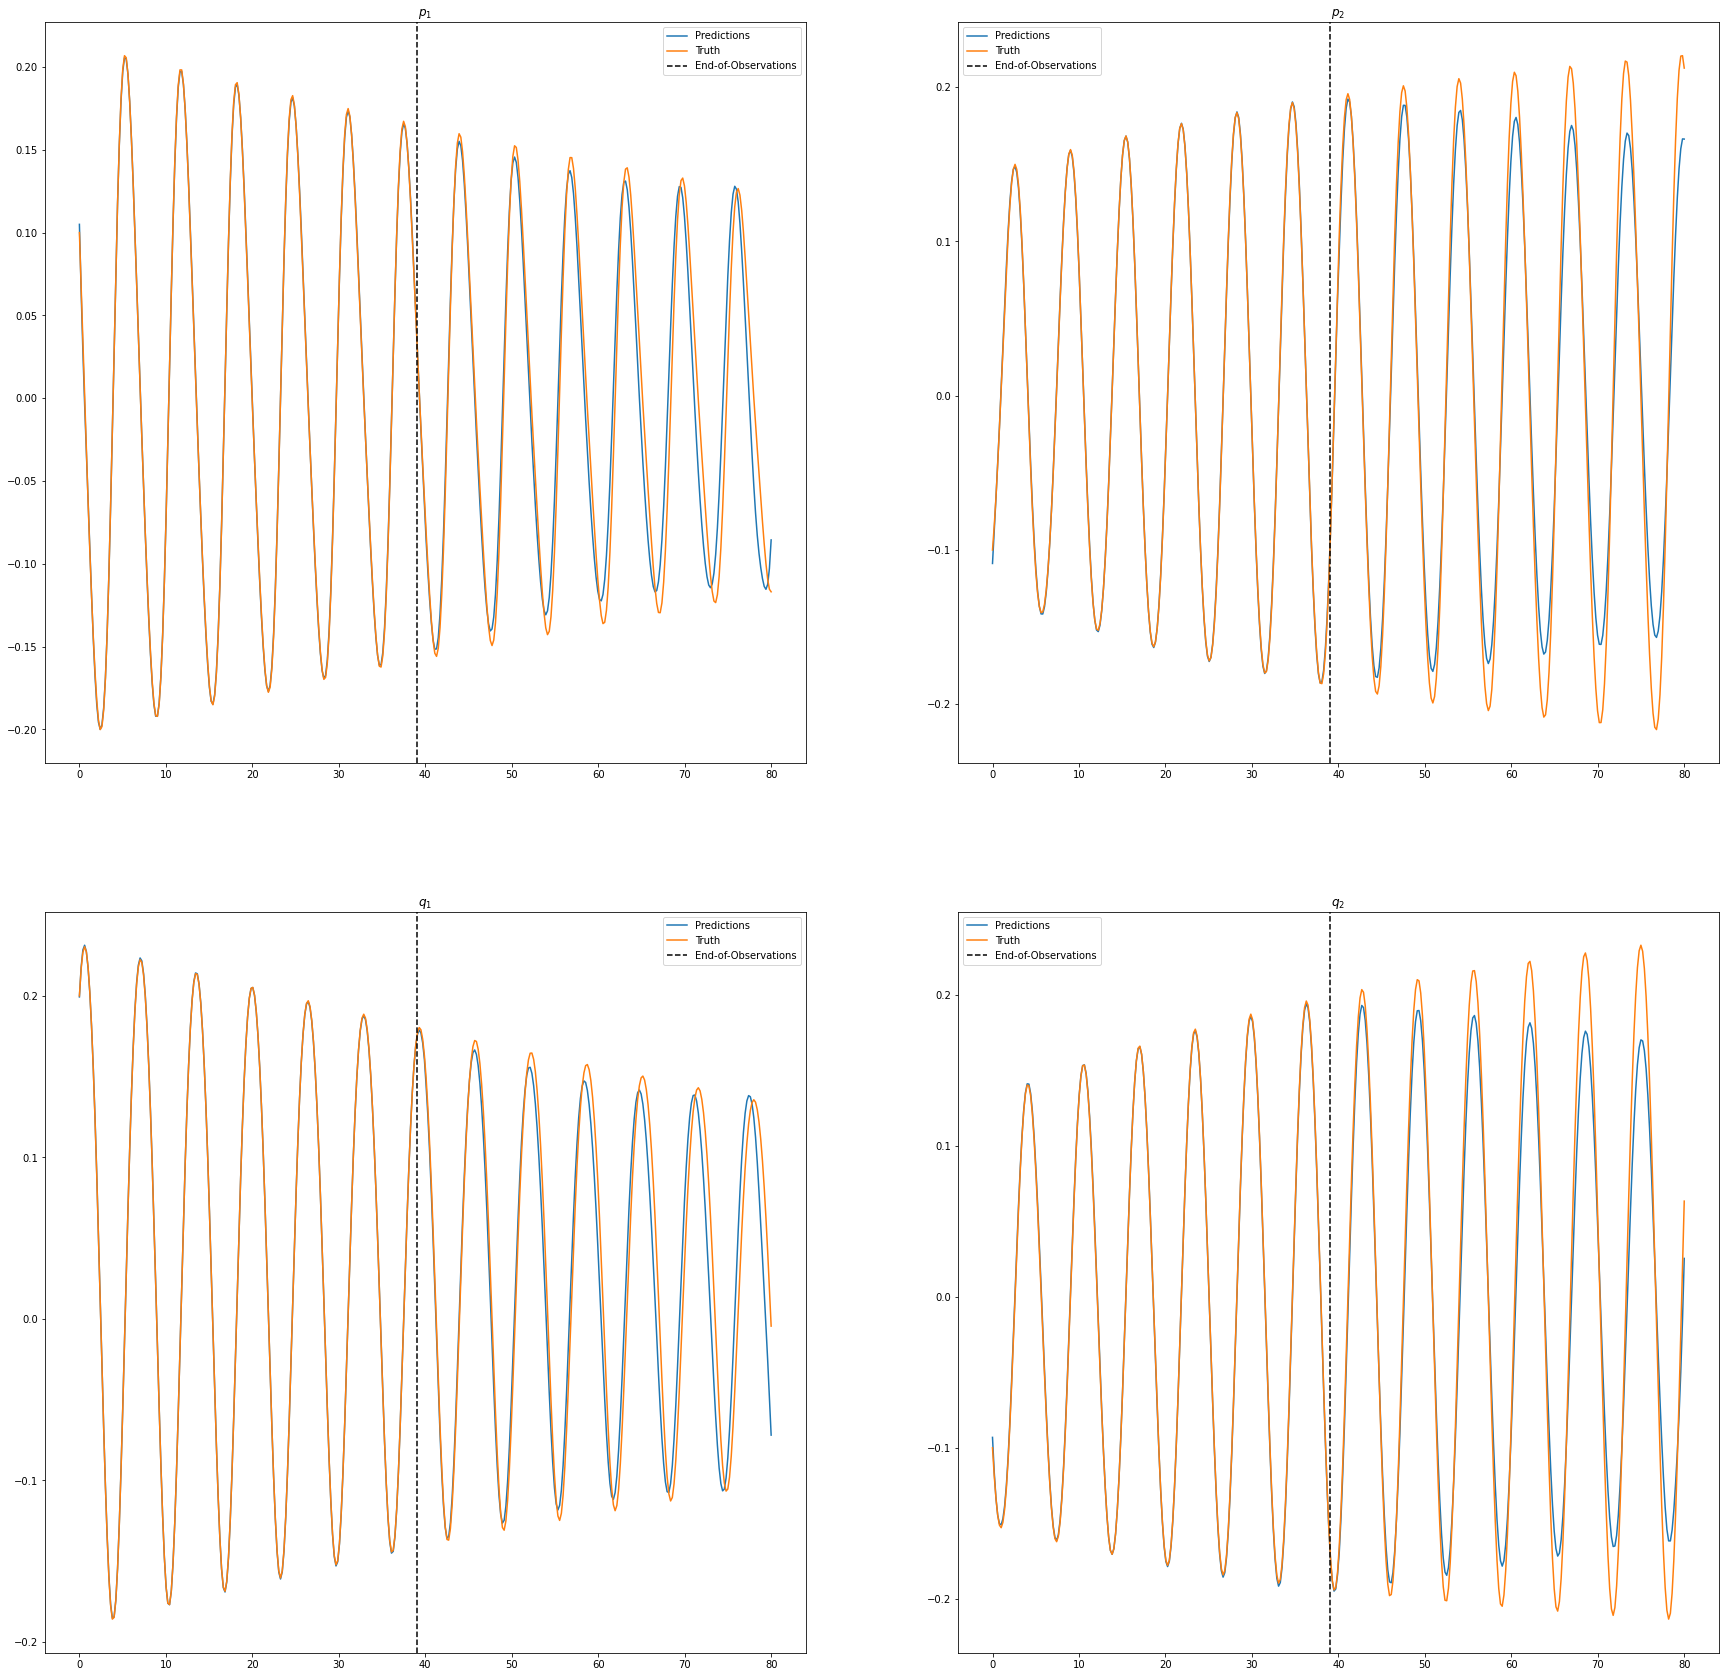

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

In [13]:
H_hh_est = get_hamiltonian_from(hh_graph, Z[:200])
H_hh_est_grad = jax.jit(jax.grad(H_hh_est))

pq_symplectic = hamiltonian_symplectic_int(H_hh_est_grad, [0.1, -0.1, 0.2, -0.1], t, order=2)
pq_symplectic = jnp.squeeze(pq_symplectic)

In [14]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1, 0]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0, 0]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1, 1]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0, 1]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.000593099
Extrapolation MSE on Q1 = 0.000667674
Extrapolation MSE on P2 = 0.000067751
Extrapolation MSE on Q2 = 0.000129292


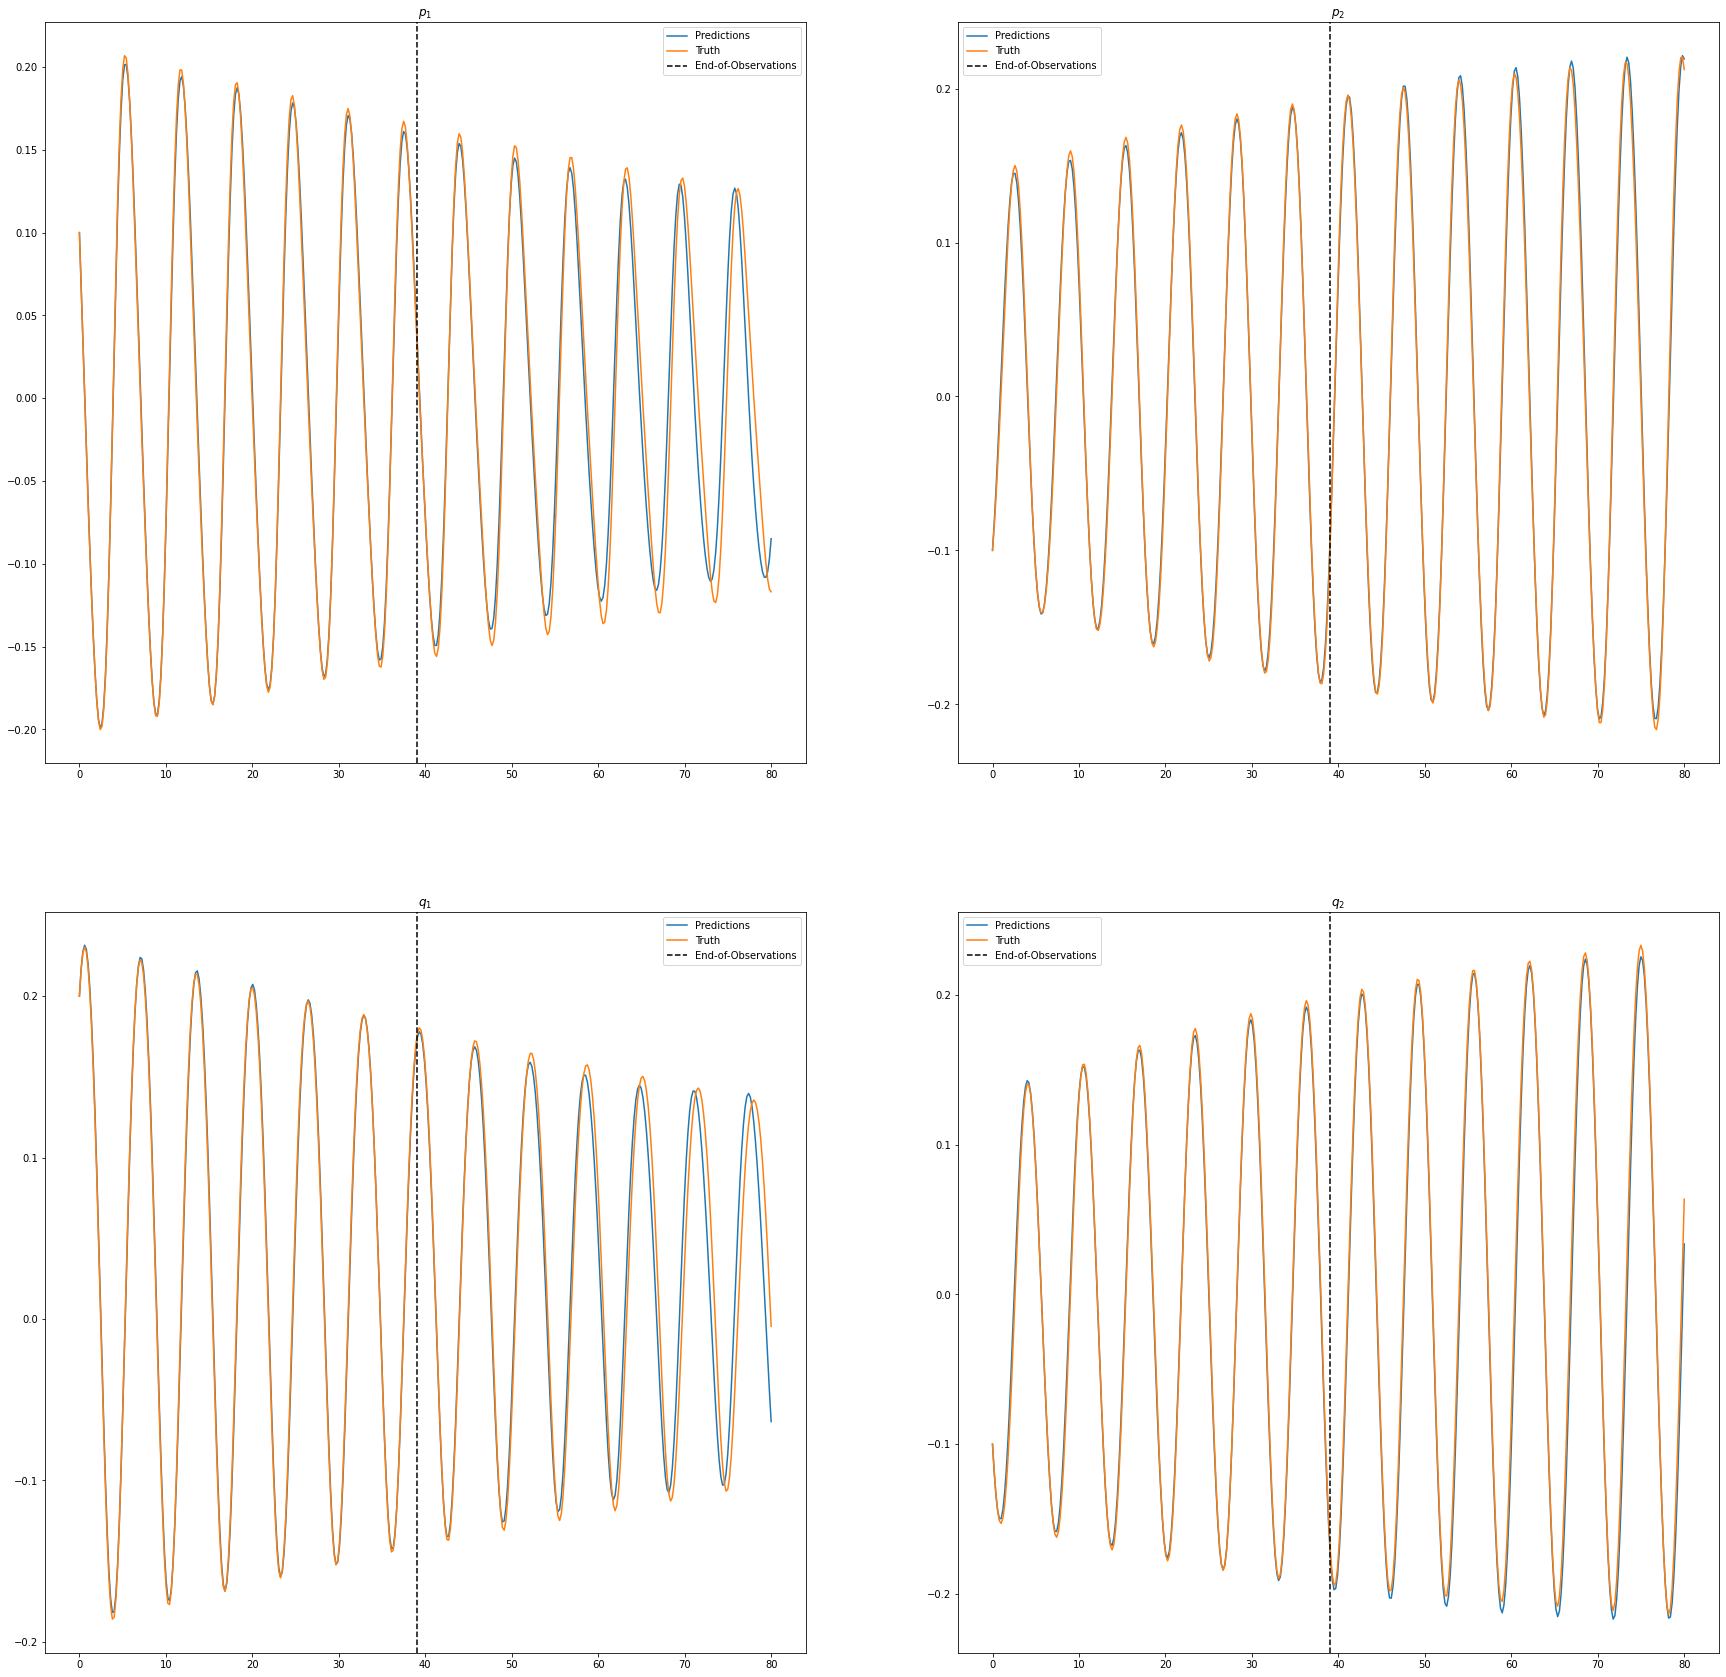

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "est", "truth", "label"])

plots_data = [
    PlotData((0, 0), pq_symplectic[:, 1, 0], p1, "$p_1$"),
    PlotData((0, 1), pq_symplectic[:, 1, 1], p2, "$p_2$"),
    PlotData((1, 0), pq_symplectic[:, 0, 0], q1, "$q_1$"),
    PlotData((1, 1), pq_symplectic[:, 0, 1], q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, data.est, label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

# Nonliner Pendulum

## Data Generation

In [5]:
import jax
import jax.numpy as jnp
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt

def H(p, q):
    return (0.5 * p ** 2) - jnp.cos(q)

def dq_H(p, q):
    return np.sin(q)

def dp_H(p, q):
    return p

p_dot = lambda p, q: -1 * dq_H(p, q)
q_dot = lambda p, q: dp_H(p, q)

def system_ode(pq, t):
    h_grad = [0, 0]
    p, q = pq
    h_grad[0] = -jnp.sin(q)
    h_grad[1] = p
    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(system_ode, [0.1, 0.95*np.pi], t=t)

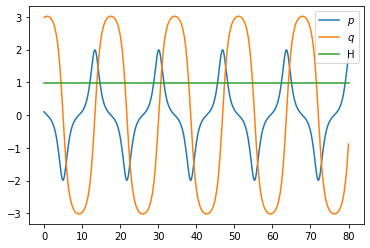

In [6]:
p, q = pq.T
H = H(p, q)

plt.plot(t, p, label="$p$")
plt.plot(t, q, label="$q$")
plt.plot(t, H, label="H")
plt.legend()

In [7]:
OBSERVATIONS_END = 200

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
    #np.full_like(H, fill_value=0.03)[:, np.newaxis]
), axis=1)

M = np.ones_like(X_true).astype(bool)
M[200:, 1:3] = False
M[:, 3] = False

X = np.full_like(X_true, fill_value=0)
X[M] = X_true[M]

In [8]:
np_graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

np_graph.add_observable("t")
np_graph.add_unknown_fn("t", "p", alpha=0.01, kernel="gaussian", kernel_parameters={"scale": KP(1, learnable=True)})
np_graph.add_unknown_fn("t", "q", alpha=0.01, kernel="gaussian", kernel_parameters={"scale": KP(1, learnable=True)})

np_graph.add_known_fn("p", "p_dot", derivative)
np_graph.add_known_fn("q", "q_dot", derivative)
np_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

np_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")

np_graph.add_aggregator(["p", "q"], "pq")
np_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, kernel="periodic", kernel_parameters={
    "period": KP(1, learnable=True),
    "scale": KP(1, learnable=True)
})
np_graph.add_known_fn("H", "grad_H", derivative)

np_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
np_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")

def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, 0], p_dot_grad_H[:, 1:]
    return p_dot + grad_H[:, 1]

def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, 0], q_dot_grad_H[:, 1:]
    return q_dot - grad_H[:, 0]

np_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
np_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [9]:
np_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [10]:
Z = np_graph.complete(X, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=5)

p


(Weights Pass) Loss: 0.0066:   0%|          | 51/500000 [00:07<19:36:27,  7.08it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0027:   0%|          | 255/500000 [00:01<38:32, 216.11it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.76400304, dtype=float32)}, 'q': {'scale': Array(1., dtype=float32)}, 'H': {'period': Array(1., dtype=float32), 'width': Array(1., dtype=float32)}}
q


(Weights Pass) Loss: 0.0142:   0%|          | 51/500000 [00:06<18:25:22,  7.54it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0111:   0%|          | 293/500000 [00:01<40:03, 207.94it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.76400304, dtype=float32)}, 'q': {'scale': Array(1.2880135, dtype=float32)}, 'H': {'period': Array(1., dtype=float32), 'width': Array(1., dtype=float32)}}
H


(Weights Pass) Loss: 2.3393:   0%|          | 51/500000 [00:10<28:34:20,  4.86it/s] 


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 1.0018:   0%|          | 100/500000 [00:02<4:01:28, 34.50it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.76400304, dtype=float32)}, 'q': {'scale': Array(1.2880135, dtype=float32)}, 'H': {'period': Array(0.99906087, dtype=float32), 'width': Array(0.99881506, dtype=float32)}}


 Loss: 4152866.7500:   0%|          | 4/10000 [00:19<13:15:39,  4.78s/it]


p


(Weights Pass) Loss: 0.5598:   0%|          | 51/500000 [00:03<10:31:51, 13.19it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.1753:   0%|          | 348/500000 [00:01<37:03, 224.73it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.4630069, dtype=float32)}, 'q': {'scale': Array(1.2880135, dtype=float32)}, 'H': {'period': Array(0.99906087, dtype=float32), 'width': Array(0.99881506, dtype=float32)}}
q


(Weights Pass) Loss: 0.2061:   0%|          | 51/500000 [00:04<11:05:55, 12.51it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0071:   0%|          | 562/500000 [00:02<40:16, 206.69it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.4630069, dtype=float32)}, 'q': {'scale': Array(0.767003, dtype=float32)}, 'H': {'period': Array(0.99906087, dtype=float32), 'width': Array(0.99881506, dtype=float32)}}
H


(Weights Pass) Loss: 7981.8438:   0%|          | 51/500000 [00:06<17:39:49,  7.86it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.9921:   0%|          | 2228/500000 [01:05<4:05:28, 33.80it/s]  


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.4630069, dtype=float32)}, 'q': {'scale': Array(0.767003, dtype=float32)}, 'H': {'period': Array(2.5401375, dtype=float32), 'width': Array(2.5414922, dtype=float32)}}
p


(Weights Pass) Loss: 0.0282:   0%|          | 51/500000 [00:04<12:32:01, 11.08it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0026:   0%|          | 327/500000 [00:01<37:47, 220.32it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.76300305, dtype=float32)}, 'q': {'scale': Array(0.767003, dtype=float32)}, 'H': {'period': Array(2.5401375, dtype=float32), 'width': Array(2.5414922, dtype=float32)}}
q


(Weights Pass) Loss: 0.0188:   0%|          | 51/500000 [00:04<10:55:27, 12.71it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0108:   0%|          | 539/500000 [00:02<36:33, 227.75it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.76300305, dtype=float32)}, 'q': {'scale': Array(1.2910136, dtype=float32)}, 'H': {'period': Array(2.5401375, dtype=float32), 'width': Array(2.5414922, dtype=float32)}}
H


(Weights Pass) Loss: 1.0303:   0%|          | 51/500000 [00:06<18:27:41,  7.52it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.9986:   0%|          | 1615/500000 [00:51<4:25:26, 31.29it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.76300305, dtype=float32)}, 'q': {'scale': Array(1.2910136, dtype=float32)}, 'H': {'period': Array(2.5316048, dtype=float32), 'width': Array(2.824959, dtype=float32)}}


 Loss: 2202390.0000:   0%|          | 3/10000 [00:17<16:14:58,  5.85s/it]


p


(Weights Pass) Loss: 0.2286:   0%|          | 51/500000 [00:04<11:12:20, 12.39it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0945:   0%|          | 294/500000 [00:01<43:49, 190.01it/s] 


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.51400626, dtype=float32)}, 'q': {'scale': Array(1.2910136, dtype=float32)}, 'H': {'period': Array(2.5316048, dtype=float32), 'width': Array(2.824959, dtype=float32)}}
q


(Weights Pass) Loss: 0.1097:   0%|          | 51/500000 [00:03<10:44:35, 12.93it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0339:   0%|          | 659/500000 [00:02<37:06, 224.27it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.51400626, dtype=float32)}, 'q': {'scale': Array(0.67100424, dtype=float32)}, 'H': {'period': Array(2.5316048, dtype=float32), 'width': Array(2.824959, dtype=float32)}}
H


(Weights Pass) Loss: 66.9782:   0%|          | 51/500000 [00:06<18:48:57,  7.38it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.9998:   0%|          | 2033/500000 [01:04<4:23:57, 31.44it/s] 


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.51400626, dtype=float32)}, 'q': {'scale': Array(0.67100424, dtype=float32)}, 'H': {'period': Array(3.9721465, dtype=float32), 'width': Array(4.1890974, dtype=float32)}}
p


(Weights Pass) Loss: 0.0828:   0%|          | 51/500000 [00:04<12:47:50, 10.85it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0365:   0%|          | 307/500000 [00:01<42:08, 197.60it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.77800286, dtype=float32)}, 'q': {'scale': Array(0.67100424, dtype=float32)}, 'H': {'period': Array(3.9721465, dtype=float32), 'width': Array(4.1890974, dtype=float32)}}
q


(Weights Pass) Loss: 0.0857:   0%|          | 51/500000 [00:04<12:01:18, 11.55it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0692:   0%|          | 235/500000 [00:01<38:53, 214.18it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.77800286, dtype=float32)}, 'q': {'scale': Array(0.48100668, dtype=float32)}, 'H': {'period': Array(3.9721465, dtype=float32), 'width': Array(4.1890974, dtype=float32)}}
H


(Weights Pass) Loss: 1.7778:   0%|          | 51/500000 [00:06<17:59:54,  7.72it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 1.6831:   0%|          | 118/500000 [00:03<3:46:35, 36.77it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.77800286, dtype=float32)}, 'q': {'scale': Array(0.48100668, dtype=float32)}, 'H': {'period': Array(3.9793816, dtype=float32), 'width': Array(4.205239, dtype=float32)}}


 Loss: 2711422.0000:   0%|          | 6/10000 [00:19<9:06:46,  3.28s/it] 


p


(Weights Pass) Loss: 0.2478:   0%|          | 51/500000 [00:04<11:57:38, 11.61it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0964:   0%|          | 314/500000 [00:01<41:44, 199.48it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.5090063, dtype=float32)}, 'q': {'scale': Array(0.48100668, dtype=float32)}, 'H': {'period': Array(3.9793816, dtype=float32), 'width': Array(4.205239, dtype=float32)}}
q


(Weights Pass) Loss: 0.3238:   0%|          | 51/500000 [00:04<11:38:44, 11.93it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.2227:   0%|          | 162/500000 [00:00<37:16, 223.53it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.5090063, dtype=float32)}, 'q': {'scale': Array(0.36600816, dtype=float32)}, 'H': {'period': Array(3.9793816, dtype=float32), 'width': Array(4.205239, dtype=float32)}}
H


(Weights Pass) Loss: 5.4499:   0%|          | 51/500000 [00:07<19:17:47,  7.20it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 1.0000:   0%|          | 201/500000 [00:05<3:44:07, 37.17it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.5090063, dtype=float32)}, 'q': {'scale': Array(0.36600816, dtype=float32)}, 'H': {'period': Array(3.8692877, dtype=float32), 'width': Array(4.1004434, dtype=float32)}}
p


(Weights Pass) Loss: 0.0831:   0%|          | 51/500000 [00:04<12:16:22, 11.32it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0484:   0%|          | 332/500000 [00:01<39:51, 208.94it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.80200255, dtype=float32)}, 'q': {'scale': Array(0.36600816, dtype=float32)}, 'H': {'period': Array(3.8692877, dtype=float32), 'width': Array(4.1004434, dtype=float32)}}
q


(Weights Pass) Loss: 0.0825:   0%|          | 51/500000 [00:04<11:35:02, 11.99it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0638:   0%|          | 157/500000 [00:00<38:02, 218.96it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.80200255, dtype=float32)}, 'q': {'scale': Array(0.47800672, dtype=float32)}, 'H': {'period': Array(3.8692877, dtype=float32), 'width': Array(4.1004434, dtype=float32)}}
H


(Weights Pass) Loss: 1.1825:   0%|          | 51/500000 [00:07<19:38:54,  7.07it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.9999:   0%|          | 60/500000 [00:01<3:42:02, 37.53it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.80200255, dtype=float32)}, 'q': {'scale': Array(0.47800672, dtype=float32)}, 'H': {'period': Array(3.8791869, dtype=float32), 'width': Array(4.1011333, dtype=float32)}}


 Loss: 1858191.1250:   0%|          | 4/10000 [00:16<11:34:41,  4.17s/it]


p


(Weights Pass) Loss: 0.1798:   0%|          | 51/500000 [00:04<10:53:31, 12.75it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0782:   0%|          | 338/500000 [00:01<37:29, 222.10it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.5090063, dtype=float32)}, 'q': {'scale': Array(0.47800672, dtype=float32)}, 'H': {'period': Array(3.8791869, dtype=float32), 'width': Array(4.1011333, dtype=float32)}}
q


(Weights Pass) Loss: 0.4066:   0%|          | 51/500000 [00:04<12:33:54, 11.05it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.2660:   0%|          | 231/500000 [00:00<35:11, 236.73it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.5090063, dtype=float32)}, 'q': {'scale': Array(0.2940091, dtype=float32)}, 'H': {'period': Array(3.8791869, dtype=float32), 'width': Array(4.1011333, dtype=float32)}}
H


(Weights Pass) Loss: 7.5707:   0%|          | 51/500000 [00:07<19:13:29,  7.22it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.9967:   0%|          | 315/500000 [00:09<4:11:11, 33.15it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.5090063, dtype=float32)}, 'q': {'scale': Array(0.2940091, dtype=float32)}, 'H': {'period': Array(4.0716395, dtype=float32), 'width': Array(4.281829, dtype=float32)}}
p


(Weights Pass) Loss: 0.0868:   0%|          | 51/500000 [00:04<13:25:40, 10.34it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0426:   0%|          | 306/500000 [00:01<44:25, 187.46it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.77000296, dtype=float32)}, 'q': {'scale': Array(0.2940091, dtype=float32)}, 'H': {'period': Array(4.0716395, dtype=float32), 'width': Array(4.281829, dtype=float32)}}
q


(Weights Pass) Loss: 0.1994:   0%|          | 51/500000 [00:04<12:58:26, 10.70it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0549:   0%|          | 663/500000 [00:03<41:06, 202.44it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.77000296, dtype=float32)}, 'q': {'scale': Array(0.91200113, dtype=float32)}, 'H': {'period': Array(4.0716395, dtype=float32), 'width': Array(4.281829, dtype=float32)}}
H


(Weights Pass) Loss: 1.3312:   0%|          | 51/500000 [00:07<20:01:24,  6.94it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.9959:   0%|          | 467/500000 [00:14<4:21:47, 31.80it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.77000296, dtype=float32)}, 'q': {'scale': Array(0.91200113, dtype=float32)}, 'H': {'period': Array(4.092412, dtype=float32), 'width': Array(4.1715784, dtype=float32)}}


 Loss: 2363844.5000:   0%|          | 7/10000 [00:20<8:11:12,  2.95s/it]  


p


(Weights Pass) Loss: 0.1662:   0%|          | 51/500000 [00:04<12:06:31, 11.47it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.0783:   0%|          | 306/500000 [00:01<39:59, 208.22it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.5090063, dtype=float32)}, 'q': {'scale': Array(0.91200113, dtype=float32)}, 'H': {'period': Array(4.092412, dtype=float32), 'width': Array(4.1715784, dtype=float32)}}
q


(Weights Pass) Loss: 0.3728:   0%|          | 51/500000 [00:04<11:34:05, 12.00it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 0.3660:   0%|          | 115/500000 [00:00<43:10, 192.96it/s]


Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.5090063, dtype=float32)}, 'q': {'scale': Array(0.9780003, dtype=float32)}, 'H': {'period': Array(4.092412, dtype=float32), 'width': Array(4.1715784, dtype=float32)}}
H


(Weights Pass) Loss: 1.0046:   0%|          | 51/500000 [00:07<19:06:34,  7.27it/s]


Stopped after 50 steps with no improvment in Loss


(Parameters Pass) Loss: 1.0001:   0%|          | 72/500000 [00:01<3:43:36, 37.26it/s]

Stopped after 50 steps with no improvment in Loss
	{'p': {'scale': Array(0.5090063, dtype=float32)}, 'q': {'scale': Array(0.9780003, dtype=float32)}, 'H': {'period': Array(4.076679, dtype=float32), 'width': Array(4.1547704, dtype=float32)}}


In [11]:
mse_p = jnp.mean((p[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)

print(f"Extrapolation MSE on P = {mse_p:.9f}")
print(f"Extrapolation MSE on Q = {mse_q:.9f}")

Extrapolation MSE on P = 0.871240497
Extrapolation MSE on Q = 6.037294865


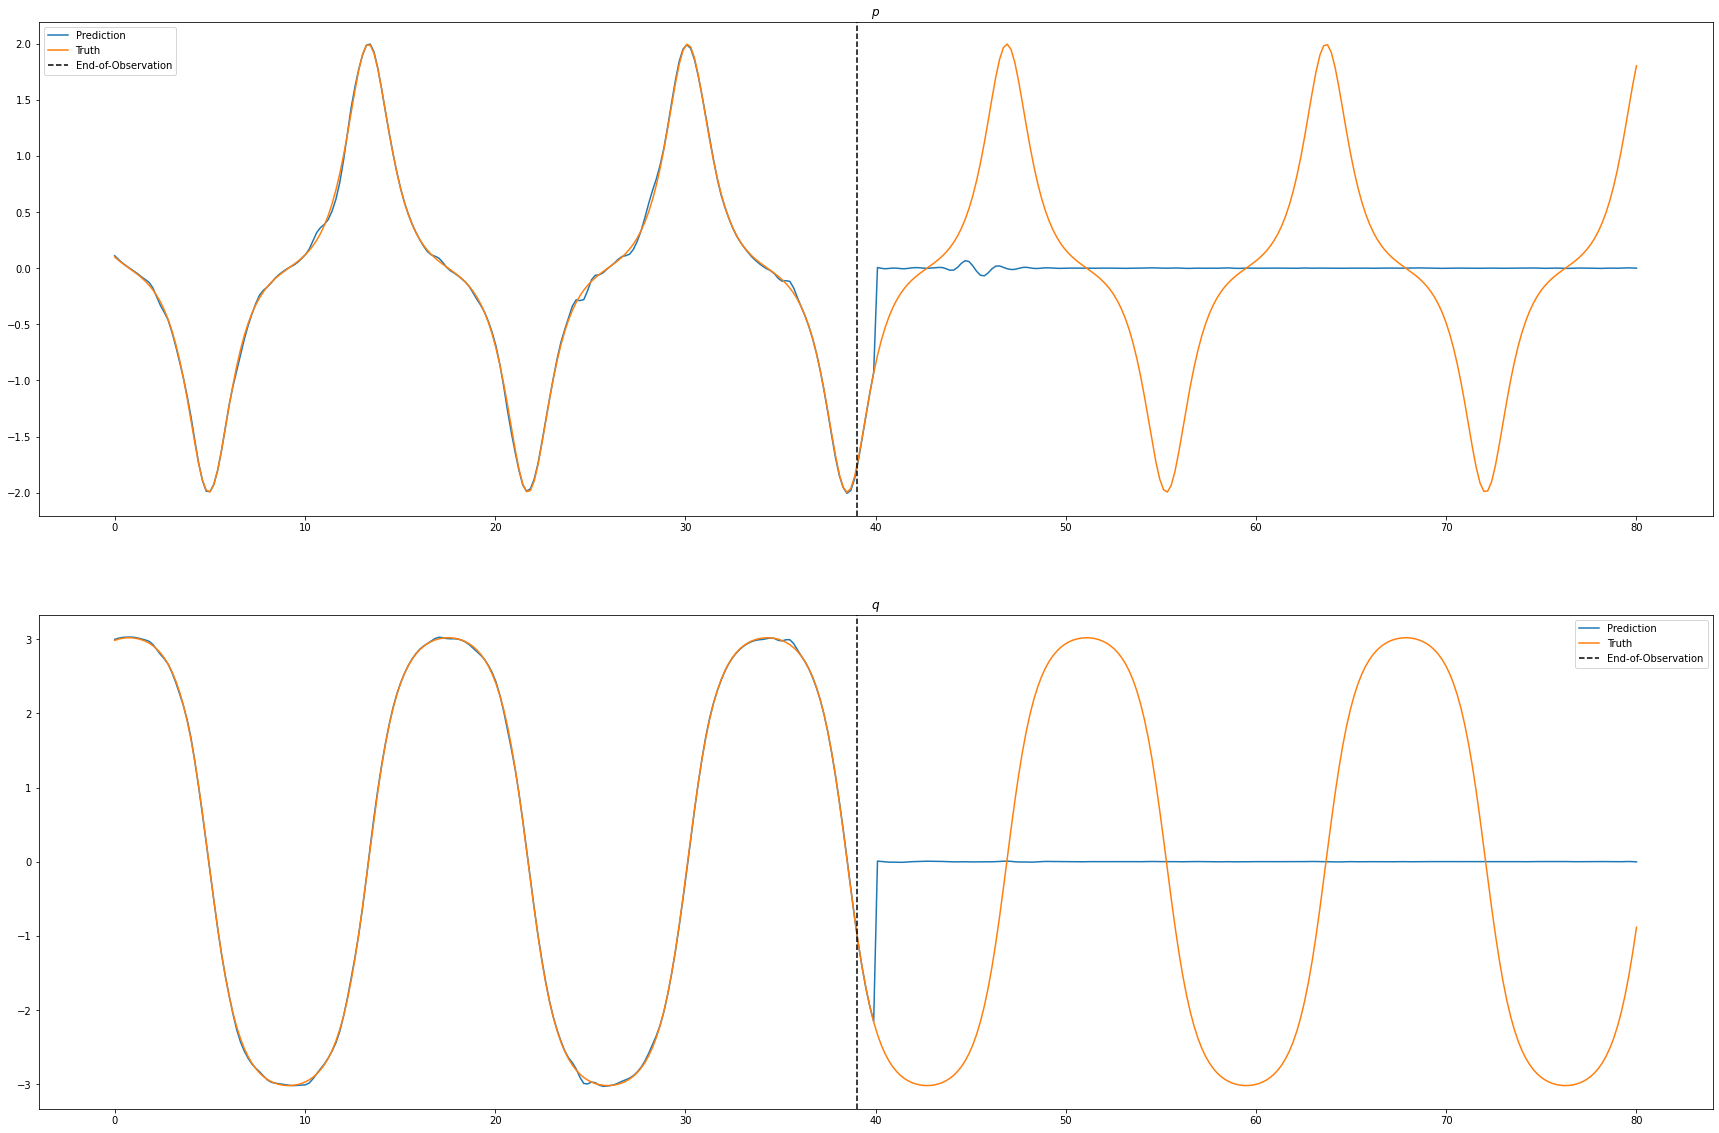

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t, Z[:, 1], label="Prediction")
axes[0].plot(t, p, label="Truth")
axes[0].set_title("$p$")
axes[0].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[0].legend()

axes[1].plot(t, Z[:, 2], label="Prediction")
axes[1].plot(t, q, label="Truth")
axes[1].set_title("$q$")
axes[1].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[1].legend()

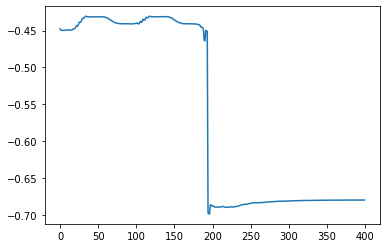

In [24]:
plt.plot(Z[:, -1])

In [13]:
H_np_est = get_hamiltonian_from(np_graph, Z[:200])
H_np_est_grad = jax.jit(jax.grad(H_np_est))

t = np.linspace(0, 80, 400)
pq_symplectic = hamiltonian_symplectic_int(H_np_est_grad, [0.1, 0.95*np.pi], t)
pq_symplectic = jnp.squeeze(pq_symplectic)

In [14]:
mse_p = jnp.mean((p[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0]) ** 2)

print(f"Extrapolation MSE on P = {mse_p:.9f}")
print(f"Extrapolation MSE on Q = {mse_q:.9f}")

Extrapolation MSE on P = 3882.994873047
Extrapolation MSE on Q = 4030.711669922


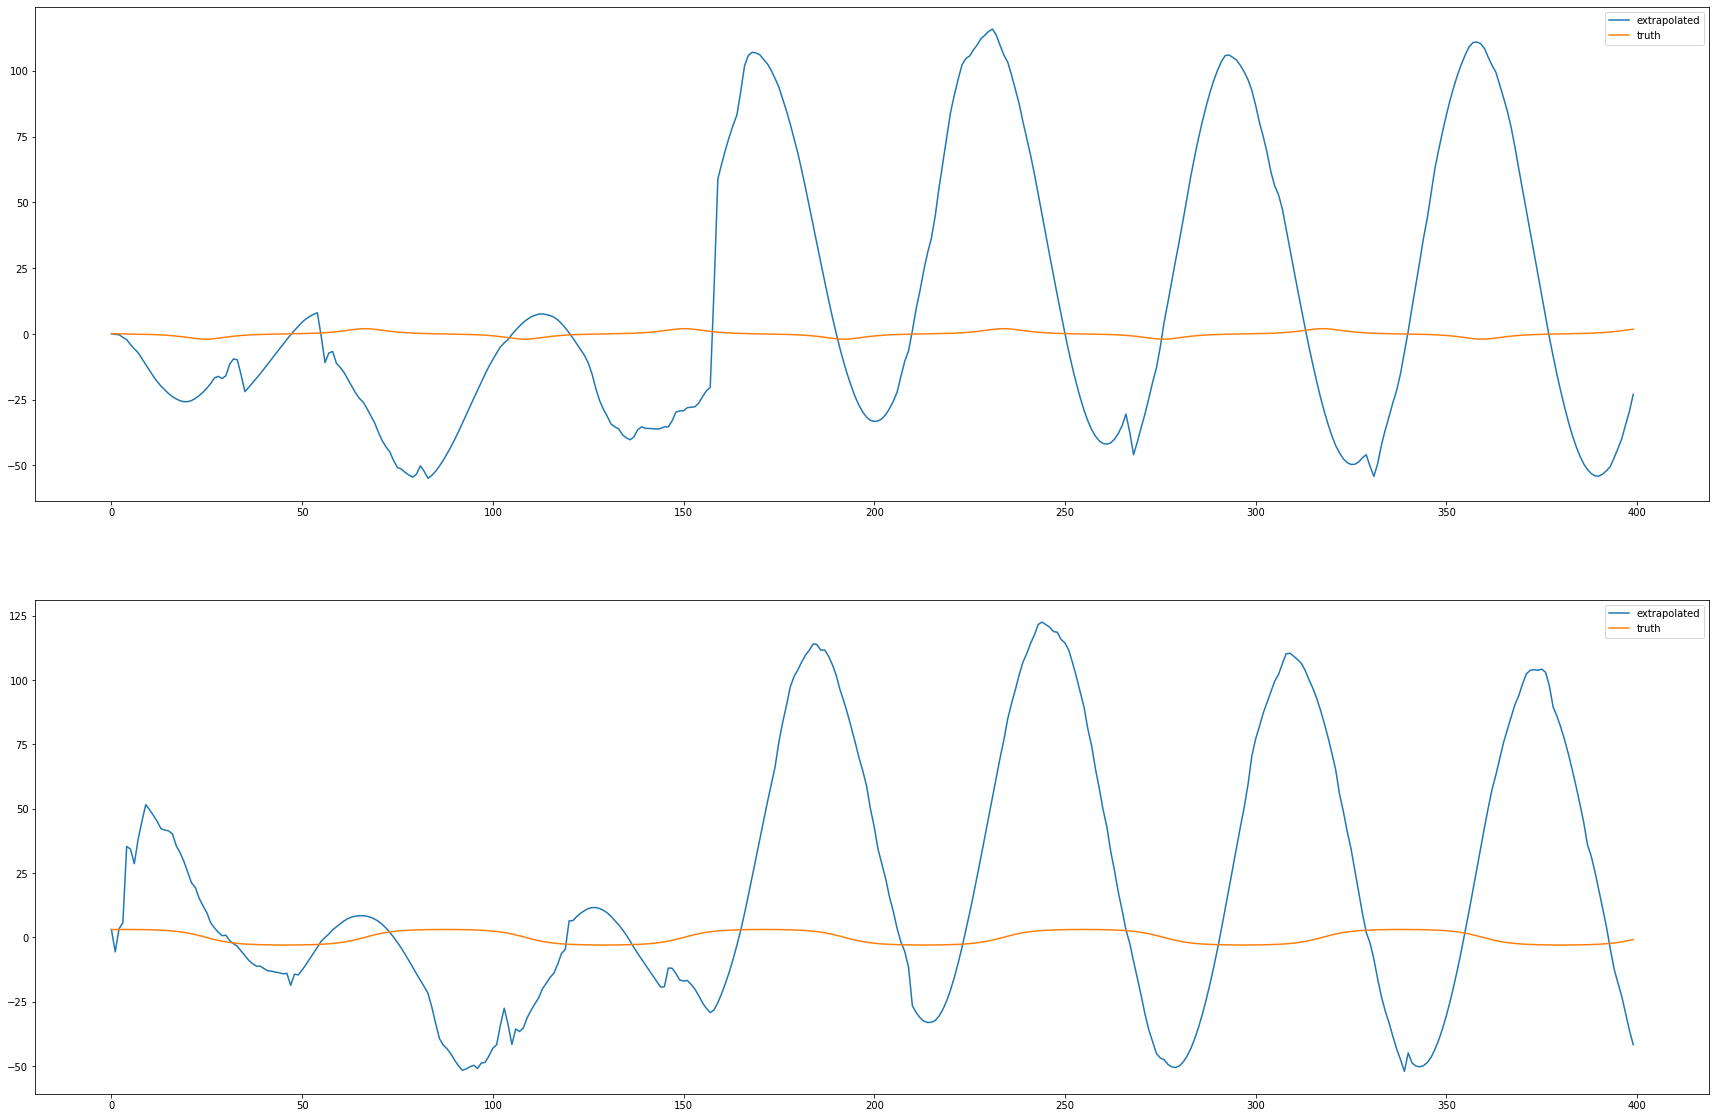

In [15]:
_, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(pq_symplectic[:, 1], label="extrapolated")
axes[0].plot(p, label="truth")
axes[0].legend()
axes[1].plot(pq_symplectic[:, 0], label="extrapolated")
axes[1].plot(q, label="truth")
axes[1].legend()

In [32]:

def _internal_f(**kwargs):
    x = kwargs.get("x")
    e = kwargs.get("e")

    return jnp.power(x, e)

def f(params):
    internal_perms = {k: v for k, v in zip(["x", "e"], params)}

    return _internal_f(**internal_perms)

In [33]:
f_grad = jax.grad(f)

In [34]:
f_grad(jnp.array([2., 3.]))

DeviceArray([12.       ,  5.5451775], dtype=float32)

In [22]:
(2 ** 3) * jnp.log(3)

DeviceArray(8.788898, dtype=float32, weak_type=True)

In [25]:
jnp.log(2.) * (2 ** 3)

DeviceArray(5.5451775, dtype=float32, weak_type=True)